# Facial Keypoints Detection
## W207 Final Project December 2017
### Arunima Kayath, Kathleen Wang, Anamika Sinha & Scott A. George

In this project, we attempted to optimize a neural network for facial keypoints detection. This notebook has three types of networks we tried for this purpose, and their variations.
Net 1 - Simple network with 1 or 2 hidden layers.
Net 2 - Convolutional Neural network with 3 convolution layers, and 2 hidden layers -one network for all 30 facial keypoints. Variations we tried with net 2 were :
    a. Data Augmentation (flipping the images horizontally and vertically)
    b. Implementing momentum increase and learning rate decay(4 different options were tried though only one is shown in the notebook)
    c. Using a Leaky Relu as the activation function instead of Relu
    d. Different combinations of filter sizes for each of the convolution layers.
Net 3 - CNN as above, but 6 different networks for 6 subsets of the 30 keypoints. This also allows us to leverage the extra data available for some of the keypoints.

In addition to this, we also tried different data pre-processing. In the time we had, we were only able to try the effect of pre-processing with net 1.

In [1]:
import os

import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from decimal import *
import tensorflow as tf
import time
from datetime import datetime
import matplotlib.pyplot as plt
from tensorflow.contrib.layers import fully_connected

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

## Loading Data

In [2]:
scott = False
aws = False
tensorboard_log = False

if scott:
    FROOT = ''
    FTRAIN = '/data/facial/training.csv'
    FTEST = '/data/facial/test.csv'
elif aws:
    FROOT = ''
    FTRAIN = '/data/training.csv'
    FTEST = '/data/test.csv'
else:
    FROOT = os.getcwd() # Path to your project folder
    FTRAIN = '~/notebooks/training.csv'
    FTEST = '~/notebooks/test.csv'

if tensorboard_log:
    root_logdir = FROOT + "tf_logs"
    
os.makedirs( FROOT + "/models/", exist_ok=True)

Helper function to load data

In [3]:
np.random.seed(0)
def load(test = False, cols = None):
    '''Loads data from FTEST if *test* is true, otherwise from FTRAIN.' 
    Pass a list of *cols* if you are only interested in a
    subset of the target columns'''
    
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname)) #load pandas dataframe

    
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im,sep=' ')) 
    #image column has pixel values separated by space; convert the values to numpy arrays
    
    if cols: #get a subset of columns
        df = df[list(cols) + ['Image']]
        
    print('Count of observations in training data by features')
    print(df.count()) #prints number of values for each column
    df = df.dropna() #drop all rows that have missing values in them
    
    X = np.vstack(df['Image'].values)/255
    X = X.astype(np.float32)
    
    if not test:
        y  = df[df.columns[:-1]].values
        y = (y-48)/48
        shuffle = np.random.permutation(np.arange(X.shape[0]))
        X, y = X[shuffle], y[shuffle]
        y = y.astype(np.float32)
    else:
        y = None
    print('done')
        
    return X,y


In [4]:
np.random.seed(0)
X, y = load()

print('Total training data')
print("X.shape = = {}; X.min == {:.3f}; X.max == {:.3f}".format(X.shape, X.min(),X.max()))
print("y.shape = = {}; y.min == {:.3f}; y.max == {:.3f}".format(y.shape, y.min(),y.max()))


Count of observations in training data by features
left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       22

Save 20% data to be used as dev data, carve out dev data and load test data

In [5]:
np.random.seed(0)
dev_size = 0.2
#setting aside a 20% sample for validation

x_train, x_dev, y_train, y_dev = train_test_split(X, y, test_size = dev_size)

x_test, _ = load(test=True)

print('Training data split into train and dev data')
print("x_train.shape = = {}; x_train.min == {:.3f}; x_train.max == {:.3f}".format(x_train.shape, x_train.min(),x_train.max()))
print("y_train.shape = = {}; y_train.min == {:.3f}; y_train.max == {:.3f}".format(y_train.shape, y_train.min(),y_train.max()))
print("x_dev.shape = = {}; x_dev.min == {:.3f}; x_dev.max == {:.3f}".format(x_dev.shape, x_dev.min(),x_dev.max()))
print("y_dev.shape = = {}; y_dev.min == {:.3f}; y_dev.max == {:.3f}".format(y_dev.shape, y_dev.min(),y_dev.max()))

Count of observations in training data by features
ImageId    1783
Image      1783
dtype: int64
done
Training data split into train and dev data
x_train.shape = = (1712, 9216); x_train.min == 0.000; x_train.max == 1.000
y_train.shape = = (1712, 30); y_train.min == -0.916; y_train.max == 0.996
x_dev.shape = = (428, 9216); x_dev.min == 0.000; x_dev.max == 1.000
y_dev.shape = = (428, 30); y_dev.min == -0.920; y_dev.max == 0.980


# KNN Baseline

In [93]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
neighbors =  [1,2,3,4,5,6,7]
row = 0
result_knn = pd.DataFrame(columns=['k_neighbours','keypoint','mse'])
print('starting')
for i in neighbors:
    knn = KNeighborsRegressor(i)
    for j in range(30):
        knn.fit(x_train, y_train[:,j])
        knn_predicted_labels = knn.predict(x_dev)
        mse = mean_squared_error(y_dev[:,j], knn_predicted_labels)
        result_knn.loc[row]= [int(i), int(j+1),  mse]
        row += 1
print("Using K-nearest neighbour, here are the mean square error(mse) for each keypoint prediction for the kth neighbour that produces the minimum mse")
min_index = [result_knn[result_knn.keypoint==i+1].mse.idxmin()  for i in range(30)]
net_loss = np.sqrt(result_knn.groupby('k_neighbours')['mse'].sum()/30)
print(net_loss)

starting
Using K-nearest neighbour, here are the mean square error(mse) for each keypoint prediction for the kth neighbour that produces the minimum mse
k_neighbours
1.0    0.058709
2.0    0.053747
3.0    0.052523
4.0    0.051666
5.0    0.051650
Name: mse, dtype: float64


## Helper functions for neural nets

### 1. plot_sample: plots sample pictures

In [6]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

In [7]:
np.random.seed(1)
def shuffle_run_batch(Xnp, ynp, Xdev, ydev, batch_size, epoch):
    """function takes training and dev data, shuffle the train data and run TF optimizer in batches for a given epoch
    It returns the average loss for training and eval of all the batches ran in the epoch.
    It expects to run with tensorboard."""

    shuffle = np.random.permutation(np.arange(Xnp.shape[0])) #shuffle the training data in each epoch
    Xnp, ynp = Xnp[shuffle], ynp[shuffle]

    # initialize variables to hold loss information for each epoch
    #loss_train = 0
    #loss_dev = 0
    batches = Xnp.shape[0]//batch_size


    for i in range(int(batches)): #run through most of the data points in each epoch
        X_batch,y_batch = Xnp[i*batch_size:(i+1)*batch_size,:], ynp[i*batch_size:(i+1)*batch_size]
        if tensorboard_log:
            if i % 10 == 0:
                train_summary_str = sqrt_loss_summary.eval(feed_dict={X: X_batch, y: y_batch, training: True})
                dev_summary_str = sqrt_loss_summary.eval(feed_dict={X: Xdev, y: ydev, training: False})
                step = epoch * batches + i
                train_writer.add_summary(train_summary_str, step)
                dev_writer.add_summary(dev_summary_str, step)

        sess.run(optimizer, feed_dict = {X:X_batch,y:y_batch, training:True})

    

        loss_train = loss.eval(feed_dict = {X:X_batch,y:y_batch,  training:True})            
        loss_dev = loss.eval(feed_dict = {X:Xdev,y:ydev, training:False})

    
    return loss_train, loss_dev
       
            

In [8]:
# *might* need to double check correctly formatted input
def plot_loss (train_loss_data, dev_loss_data):
    
    plt.figure()
    plt.plot(train_loss_data[:,1], label="train")
    plt.plot(dev_loss_data[:,1], linewidth=3, label="valid")
    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.yscale("log")
    plt.show()

In [9]:
# *might* need to double check correctly formatted input
def plot_pred (x_dev, y_pred):
    
    fig = plt.figure(figsize=(16, 16))
    fig.subplots_adjust(
        left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(4):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        plot_sample(x_dev[i], y_pred[i], ax)
    plt.show
    


## First model: 1 hidden layer simple neural net

Define parameters

In [88]:
learning_rate = 0.01
momentum = 0.9

n_epochs = 1501 #Although net 1 reaches steady state sooner, standarsized to this many epochs for all nets for comparison
batch_size = 50


n_inputs = X.shape[1] 
n_hidden1 = 100
n_outputs = 30


Construct the tensorflow graph for the first network

0 Train loss:0.133 Dev loss:0.132 ratio train/dev:1.01
50 Train loss:0.067 Dev loss:0.072 ratio train/dev:0.93
100 Train loss:0.061 Dev loss:0.065 ratio train/dev:0.94
150 Train loss:0.051 Dev loss:0.060 ratio train/dev:0.85
200 Train loss:0.047 Dev loss:0.057 ratio train/dev:0.82
250 Train loss:0.045 Dev loss:0.057 ratio train/dev:0.80
300 Train loss:0.046 Dev loss:0.055 ratio train/dev:0.83
350 Train loss:0.044 Dev loss:0.055 ratio train/dev:0.80
400 Train loss:0.043 Dev loss:0.055 ratio train/dev:0.79
450 Train loss:0.042 Dev loss:0.054 ratio train/dev:0.78
500 Train loss:0.042 Dev loss:0.053 ratio train/dev:0.78
550 Train loss:0.037 Dev loss:0.053 ratio train/dev:0.70
600 Train loss:0.040 Dev loss:0.053 ratio train/dev:0.75
650 Train loss:0.035 Dev loss:0.053 ratio train/dev:0.66
700 Train loss:0.036 Dev loss:0.053 ratio train/dev:0.69
750 Train loss:0.032 Dev loss:0.052 ratio train/dev:0.60
800 Train loss:0.037 Dev loss:0.053 ratio train/dev:0.71
850 Train loss:0.031 Dev loss:0.05

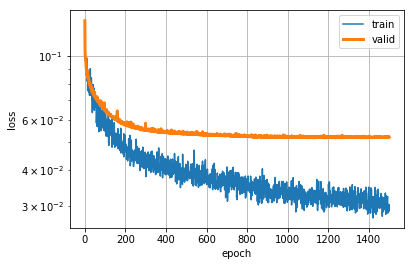

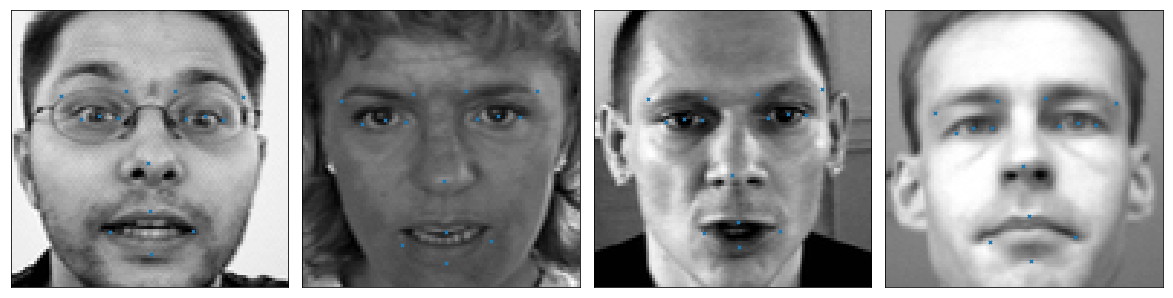

In [89]:
#Net 1 - network with 1 hidden layer.
np.random.seed(1)
tf.reset_default_graph()

X = tf.placeholder(tf.float32,shape = (None,n_inputs),name = 'X')
y = tf.placeholder(tf.float32,shape = (None,n_outputs),name = 'y')
training = tf.placeholder(tf.bool)

if tensorboard_log:
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    logdir = "{}/run-{}/".format(root_logdir, now)


with tf.name_scope('dnn'):
    hidden1 = fully_connected(X,n_hidden1,scope = 'hidden1')
    pred_keypoints = fully_connected(hidden1,n_outputs,activation_fn = None,scope = 'outputs')
    
    
with tf.name_scope('loss'):
    loss = tf.reduce_mean(np.square(pred_keypoints - y))   
    sqrt_loss = tf.sqrt(loss)

with tf.name_scope('train'):
    optimizer = tf.train.MomentumOptimizer(learning_rate = learning_rate,momentum = momentum).minimize(loss) 
    #works better than gradientdescentoptimizer

#for tensorboard
with tf.name_scope('summaries'):
    sqrt_loss_summary = tf.summary.scalar('sqrt_loss', sqrt_loss)


if tensorboard_log:
    train_writer = tf.summary.FileWriter(logdir + '/train', tf.get_default_graph())
    dev_writer =  tf.summary.FileWriter(logdir + '/dev')
    
init = tf.global_variables_initializer()


train_loss_data = np.zeros((n_epochs,2))
dev_loss_data = np.zeros((n_epochs,2))

time_start = time.time()
time_1000_start = time.time()

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        
        # note this is includes the for-loop for batching
        loss_train,loss_dev = shuffle_run_batch (x_train, y_train, x_dev, y_dev, batch_size, epoch)
                    
        train_loss_data[epoch,:] = epoch,np.sqrt(loss_train)
        dev_loss_data[epoch,:] = epoch,np.sqrt(loss_dev)

            
        if epoch%50 == 0:
            print(epoch,'Train loss:%0.3f'%np.sqrt(loss_train),
                  'Dev loss:%0.3f'%np.sqrt(loss_dev),
                  'ratio train/dev:%0.2f'%np.sqrt(loss_train/loss_dev))
            
    time_end = time.time()  
    y_pred = sess.run(pred_keypoints,feed_dict = {X: x_test})
    print('Total time taken:',time_end-time_start)

if tensorboard_log:
    train_writer.close()
    dev_writer.close()
    
#Plotting loss, and sample predictions
plt.figure()
plot_loss (train_loss_data, dev_loss_data)
plot_pred (x_test, y_pred) #updated this to be x_test instead of x_dev, since the predictions are being made on x_test

#Saving loss and test predictions
train_dev_loss = np.hstack((train_loss_data,dev_loss_data))
with open('net1_baseline.csv', 'wb') as fp:
    np.savetxt(fp, train_dev_loss,fmt = '%0.4f')
with open('net1_baseline_test_pred.csv','wb') as fs:
    np.savetxt(fs,y_pred,fmt = '%0.4f')



# Fully Connected Network(Net 1) with 2 hidden layers

0 Train loss:0.129 Dev loss:0.125 ratio train/dev:1.04
50 Train loss:0.058 Dev loss:0.062 ratio train/dev:0.93
100 Train loss:0.055 Dev loss:0.057 ratio train/dev:0.98
150 Train loss:0.048 Dev loss:0.055 ratio train/dev:0.88
200 Train loss:0.044 Dev loss:0.053 ratio train/dev:0.83
250 Train loss:0.040 Dev loss:0.052 ratio train/dev:0.77
300 Train loss:0.043 Dev loss:0.051 ratio train/dev:0.83
350 Train loss:0.041 Dev loss:0.051 ratio train/dev:0.81
400 Train loss:0.038 Dev loss:0.050 ratio train/dev:0.76
450 Train loss:0.038 Dev loss:0.050 ratio train/dev:0.75
500 Train loss:0.037 Dev loss:0.050 ratio train/dev:0.74
550 Train loss:0.032 Dev loss:0.050 ratio train/dev:0.64
600 Train loss:0.035 Dev loss:0.050 ratio train/dev:0.71
650 Train loss:0.030 Dev loss:0.049 ratio train/dev:0.62
700 Train loss:0.031 Dev loss:0.050 ratio train/dev:0.63
750 Train loss:0.027 Dev loss:0.049 ratio train/dev:0.55
800 Train loss:0.032 Dev loss:0.049 ratio train/dev:0.64
850 Train loss:0.027 Dev loss:0.04

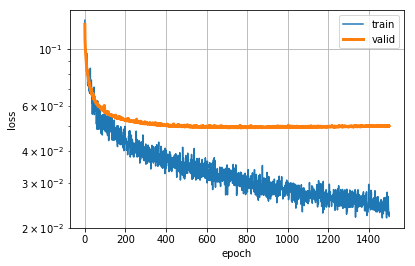

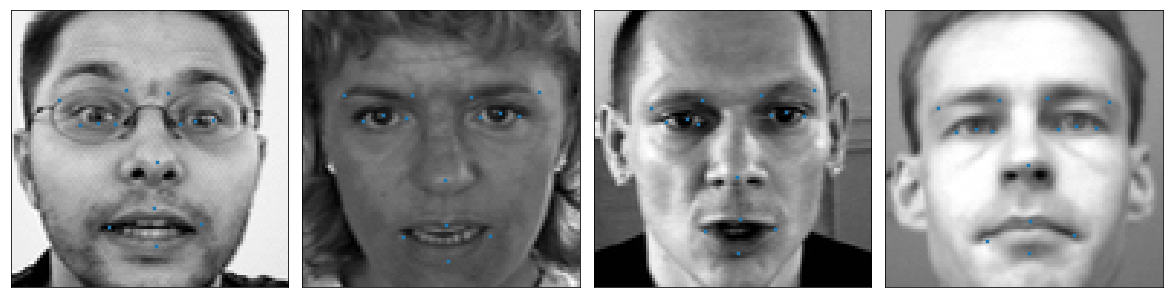

In [90]:
#Net 1 with 2 hidden layers
n_hidden2 = 60
np.random.seed(1)
tf.reset_default_graph()

X = tf.placeholder(tf.float32,shape = (None,n_inputs),name = 'X')
y = tf.placeholder(tf.float32,shape = (None,n_outputs),name = 'y')
training = tf.placeholder(tf.bool)

if tensorboard_log:
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    logdir = "{}/run-{}/".format(root_logdir, now)
    
with tf.name_scope('dnn'):
    hidden1 = fully_connected(X,n_hidden1,scope = 'hidden1')
    hidden2 = fully_connected(hidden1,n_hidden2,scope = 'hidden2')
    pred_keypoints = fully_connected(hidden2,n_outputs,activation_fn = None,scope = 'outputs')
    
with tf.name_scope('loss'):
    loss = tf.reduce_mean(np.square(pred_keypoints - y))   
    sqrt_loss = tf.sqrt(loss)

with tf.name_scope('train'):
    optimizer = tf.train.MomentumOptimizer(learning_rate = learning_rate,momentum = momentum).minimize(loss) 
    #works better than gradientdescentoptimizer

#for tensorboard
with tf.name_scope('summaries'):
    sqrt_loss_summary = tf.summary.scalar('sqrt_loss', sqrt_loss)


if tensorboard_log:
    train_writer = tf.summary.FileWriter(logdir + '/train', tf.get_default_graph())
    dev_writer =  tf.summary.FileWriter(logdir + '/dev')
    
init = tf.global_variables_initializer()


train_loss_data = np.zeros((n_epochs,2))
dev_loss_data = np.zeros((n_epochs,2))

time_start = time.time()
time_1000_start = time.time()

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        
        # note this is includes the for-loop for batching
        loss_train,loss_dev = shuffle_run_batch (x_train, y_train, x_dev, y_dev, batch_size, epoch)
                    
        train_loss_data[epoch,:] = epoch,np.sqrt(loss_train)
        dev_loss_data[epoch,:] = epoch,np.sqrt(loss_dev)

            
        if epoch%50 == 0:
            print(epoch,'Train loss:%0.3f'%np.sqrt(loss_train),
                  'Dev loss:%0.3f'%np.sqrt(loss_dev),
                  'ratio train/dev:%0.2f'%np.sqrt(loss_train/loss_dev))
            
            
    time_end = time.time()  
    
    y_pred = sess.run(pred_keypoints,feed_dict = {X: x_test})
   
    print('Total time taken:',time_end-time_start)
    
if tensorboard_log:
    train_writer.close()
    dev_writer.close()
    
plt.figure()
plot_loss (train_loss_data, dev_loss_data)
plot_pred (x_test, y_pred)

#Saving loss and test predictions
train_dev_loss = np.hstack((train_loss_data,dev_loss_data))
with open('net1_2hidden_layers.csv', 'wb') as fp:
    np.savetxt(fp, train_dev_loss,fmt = '%0.4f')
with open('net1__2hidden_layers_test_pred.csv','wb') as fs:
    np.savetxt(fs,y_pred,fmt = '%0.4f')


Helper function to pre-process the data in different ways. Three types of pre-processing were tried:
    a. Max_range : Stretches each image to the maximum pixel range eg is the lowest and highest pixel in an image is 0.2,0.7, then these will be stretched by dividing all the pixels by (0.7-0.2) = 0.5
    b. Gaussian_blur : Gaussian blur of 3X3
    c. Mean_center : Subtract the mean image from all the images.

In [95]:
#Function to pre-process the data in different ways
def preprocess_image(x,type):
    x1 = np.zeros(x.shape)
    mean_x = np.mean(x,axis=1)
    max_x = np.max(x,axis=1)
    min_x = np.min(x,axis=1)
    std_x = np.std(x,axis=1)
    delta_x_arr = max_x - min_x
    
    if type == 'None': #No pre-processing baseline
        x1 = x
    
    if type == 'Max_range': #Divide all x's in a row by the max in the range
        for i in range(x.shape[0]):
            delta_x = max_x[i] - min_x[i]
            x1[i,:] = (x[i,:])/delta_x
        

    if type == 'Gaussian_blur': #3X3 gaussian blur of the image
        #print(len(x))
        for k in range(len(x)):
            tmp_array = x[k].reshape(96,96)
            tmp_array_copy = tmp_array
            for i in range(tmp_array.shape[0]-1):
                for j in range(tmp_array.shape[1] -1):
                    if (i > 0 and j > 0):
                        sub_arr = tmp_array[i-1:i+1,j-1:j+1]
                        sum8 = (1/4)*tmp_array[i,j]+(1/8)*(tmp_array[i-1,j]+tmp_array[i+1,j]+tmp_array[i,j-1]+tmp_array[i,j+1])\
                        + (1/16)*(tmp_array[i-1,j-1]+tmp_array[i-1,j+1]+tmp_array[i+1,j-1]+tmp_array[i+1,j+1])
                        tmp_array_copy[i,j] = sum8
            tmp_array = tmp_array_copy.reshape(9216)
            x1[k] = tmp_array
            
    if type == 'Mean_center': #Take out the mean image from all images (effectively taking out the mean of each feature)
        feature_mean = np.mean(x,axis=0)
        #print('feature_mean_shape',feature_mean.shape)
        for i in range(x.shape[1]):
            x1[:,i] = x[:,i]-feature_mean[i]
   
    return x1

Neural net with 1 hidden layer and trying all of the above 3 variations of preprocessed input

0 Train loss:0.128 Dev loss:0.124 ratio train/dev:1.03
50 Train loss:0.068 Dev loss:0.073 ratio train/dev:0.93
100 Train loss:0.057 Dev loss:0.064 ratio train/dev:0.90
150 Train loss:0.050 Dev loss:0.060 ratio train/dev:0.83
200 Train loss:0.045 Dev loss:0.058 ratio train/dev:0.78
250 Train loss:0.043 Dev loss:0.056 ratio train/dev:0.76
300 Train loss:0.044 Dev loss:0.056 ratio train/dev:0.80
350 Train loss:0.042 Dev loss:0.055 ratio train/dev:0.77
400 Train loss:0.040 Dev loss:0.054 ratio train/dev:0.73
450 Train loss:0.040 Dev loss:0.054 ratio train/dev:0.73
500 Train loss:0.040 Dev loss:0.053 ratio train/dev:0.75
550 Train loss:0.035 Dev loss:0.053 ratio train/dev:0.65
600 Train loss:0.037 Dev loss:0.053 ratio train/dev:0.69
650 Train loss:0.033 Dev loss:0.053 ratio train/dev:0.63
700 Train loss:0.034 Dev loss:0.053 ratio train/dev:0.64
750 Train loss:0.028 Dev loss:0.052 ratio train/dev:0.53
800 Train loss:0.035 Dev loss:0.053 ratio train/dev:0.65
850 Train loss:0.028 Dev loss:0.05

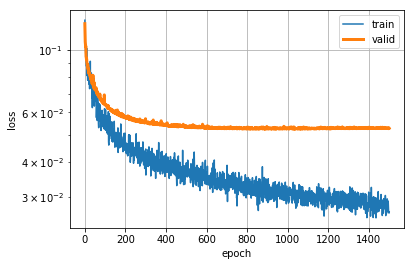

0 Train loss:0.131 Dev loss:0.132 ratio train/dev:0.99
50 Train loss:0.071 Dev loss:0.071 ratio train/dev:1.01
100 Train loss:0.057 Dev loss:0.062 ratio train/dev:0.92
150 Train loss:0.052 Dev loss:0.060 ratio train/dev:0.87
200 Train loss:0.043 Dev loss:0.056 ratio train/dev:0.76
250 Train loss:0.042 Dev loss:0.055 ratio train/dev:0.76
300 Train loss:0.039 Dev loss:0.054 ratio train/dev:0.72
350 Train loss:0.039 Dev loss:0.054 ratio train/dev:0.71
400 Train loss:0.041 Dev loss:0.053 ratio train/dev:0.77
450 Train loss:0.036 Dev loss:0.053 ratio train/dev:0.69
500 Train loss:0.037 Dev loss:0.053 ratio train/dev:0.70
550 Train loss:0.032 Dev loss:0.052 ratio train/dev:0.62
600 Train loss:0.037 Dev loss:0.052 ratio train/dev:0.72
650 Train loss:0.032 Dev loss:0.052 ratio train/dev:0.62
700 Train loss:0.036 Dev loss:0.052 ratio train/dev:0.70
750 Train loss:0.033 Dev loss:0.052 ratio train/dev:0.63
800 Train loss:0.031 Dev loss:0.052 ratio train/dev:0.59
850 Train loss:0.034 Dev loss:0.05

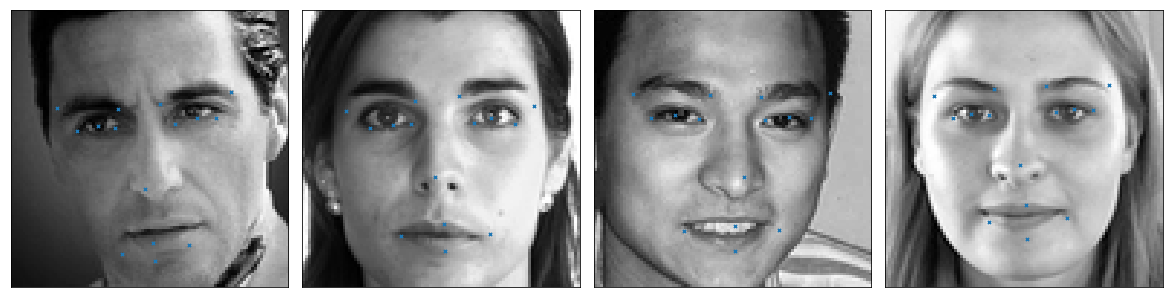

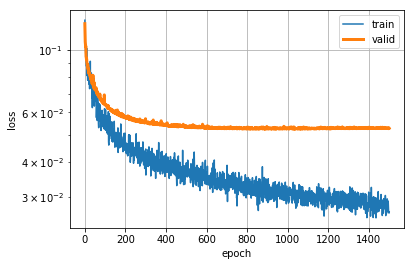

0 Train loss:0.218 Dev loss:0.211 ratio train/dev:1.03
50 Train loss:0.057 Dev loss:0.088 ratio train/dev:0.65
100 Train loss:0.042 Dev loss:0.081 ratio train/dev:0.52
150 Train loss:0.037 Dev loss:0.079 ratio train/dev:0.47
200 Train loss:0.033 Dev loss:0.077 ratio train/dev:0.43
250 Train loss:0.031 Dev loss:0.076 ratio train/dev:0.41
300 Train loss:0.030 Dev loss:0.076 ratio train/dev:0.39
350 Train loss:0.027 Dev loss:0.075 ratio train/dev:0.36
400 Train loss:0.026 Dev loss:0.075 ratio train/dev:0.34
450 Train loss:0.024 Dev loss:0.074 ratio train/dev:0.32
500 Train loss:0.024 Dev loss:0.074 ratio train/dev:0.32
550 Train loss:0.023 Dev loss:0.074 ratio train/dev:0.31
600 Train loss:0.021 Dev loss:0.074 ratio train/dev:0.29
650 Train loss:0.019 Dev loss:0.074 ratio train/dev:0.26
700 Train loss:0.020 Dev loss:0.074 ratio train/dev:0.27
750 Train loss:0.019 Dev loss:0.074 ratio train/dev:0.26
800 Train loss:0.019 Dev loss:0.073 ratio train/dev:0.26
850 Train loss:0.017 Dev loss:0.07

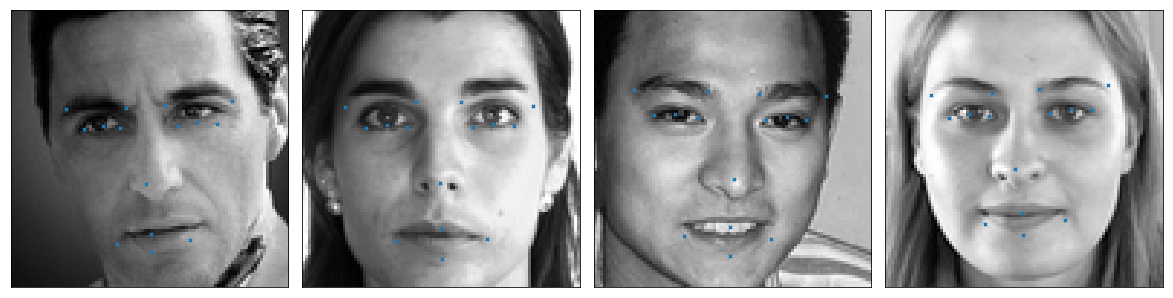

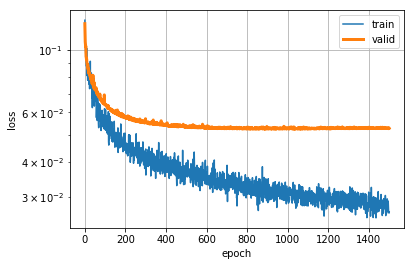

0 Train loss:0.130 Dev loss:0.124 ratio train/dev:1.05
50 Train loss:0.072 Dev loss:0.069 ratio train/dev:1.03
100 Train loss:0.062 Dev loss:0.062 ratio train/dev:0.99
150 Train loss:0.053 Dev loss:0.059 ratio train/dev:0.89
200 Train loss:0.049 Dev loss:0.057 ratio train/dev:0.86
250 Train loss:0.050 Dev loss:0.055 ratio train/dev:0.92
300 Train loss:0.045 Dev loss:0.054 ratio train/dev:0.83
350 Train loss:0.047 Dev loss:0.054 ratio train/dev:0.87
400 Train loss:0.044 Dev loss:0.052 ratio train/dev:0.84
450 Train loss:0.044 Dev loss:0.053 ratio train/dev:0.84
500 Train loss:0.043 Dev loss:0.051 ratio train/dev:0.84
550 Train loss:0.039 Dev loss:0.052 ratio train/dev:0.74
600 Train loss:0.038 Dev loss:0.051 ratio train/dev:0.74
650 Train loss:0.042 Dev loss:0.051 ratio train/dev:0.82
700 Train loss:0.041 Dev loss:0.051 ratio train/dev:0.81
750 Train loss:0.036 Dev loss:0.051 ratio train/dev:0.71
800 Train loss:0.042 Dev loss:0.051 ratio train/dev:0.83
850 Train loss:0.034 Dev loss:0.05

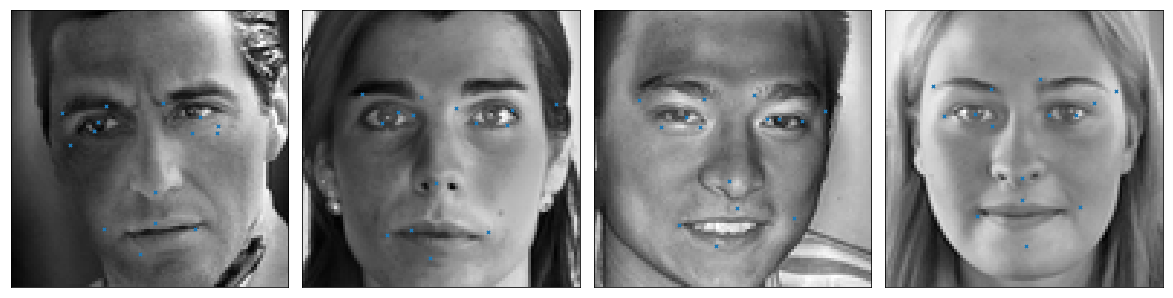

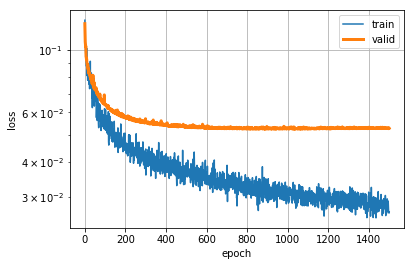

Total time taken: 2402.174376964569


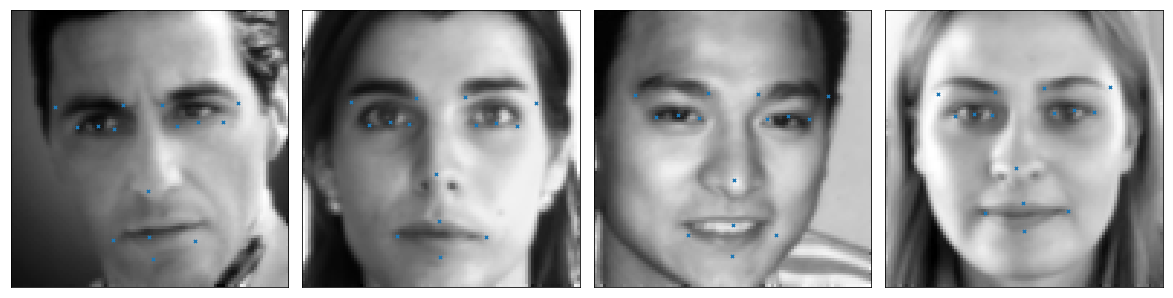

In [96]:
#net 1 with 1 hidden layer and preprocessed input
np.random.seed(1)
tf.reset_default_graph()

X = tf.placeholder(tf.float32,shape = (None,n_inputs),name = 'X')
y = tf.placeholder(tf.float32,shape = (None,n_outputs),name = 'y')
training = tf.placeholder(tf.bool)

if tensorboard_log:
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    logdir = "{}/run-{}/".format(root_logdir, now)


with tf.name_scope('dnn'):
    hidden1 = fully_connected(X,n_hidden1,scope = 'hidden1')
    pred_keypoints = fully_connected(hidden1,n_outputs,activation_fn = None,scope = 'outputs')
    
    
with tf.name_scope('loss'):
    loss = tf.reduce_mean(np.square(pred_keypoints - y))   
    sqrt_loss = tf.sqrt(loss)

with tf.name_scope('train'):
    optimizer = tf.train.MomentumOptimizer(learning_rate = learning_rate,momentum = momentum).minimize(loss) 
    #works better than gradientdescentoptimizer

#for tensorboard
with tf.name_scope('summaries'):
    sqrt_loss_summary = tf.summary.scalar('sqrt_loss', sqrt_loss)


if tensorboard_log:
    train_writer = tf.summary.FileWriter(logdir + '/train', tf.get_default_graph())
    dev_writer =  tf.summary.FileWriter(logdir + '/dev')
    
init = tf.global_variables_initializer()

preprocess_types = ('None','Max_range','Mean_center','Gaussian_blur')

train_loss_data = np.zeros((n_epochs,len(preprocess_types)+1))
dev_loss_data = np.zeros((n_epochs,len(preprocess_types)+1))

time_start = time.time()
time_1000_start = time.time()

preprocess_types = ('None','Max_range','Mean_center','Gaussian_blur')

with tf.Session() as sess:
    
    i = 0
    for type in preprocess_types:
        sess.run(tf.global_variables_initializer())
        #modify the train and dev data to be digitized to just 10 pixel values
        x_train_preprocess = preprocess_image(x_train,type)
        x_dev_preprocess = preprocess_image(x_dev,type)
        x_test_preprocess = preprocess_image(x_test,type)
        for epoch in range(n_epochs):

            loss_train,loss_dev = shuffle_run_batch (x_train_preprocess, y_train, x_dev_preprocess, y_dev, batch_size, epoch)

            train_loss_data[epoch,0] = epoch
            dev_loss_data[epoch,0] = epoch
            train_loss_data[epoch,i+1] = np.sqrt(loss_train)
            dev_loss_data[epoch,i+1] = np.sqrt(loss_dev)
            
            if epoch%50 == 0:
                print(epoch,'Train loss:%0.3f'%np.sqrt(loss_train),
                      'Dev loss:%0.3f'%np.sqrt(loss_dev),
                      'ratio train/dev:%0.2f'%np.sqrt(loss_train/loss_dev))
        
        i+=1
        y_pred = sess.run(pred_keypoints,feed_dict = {X: x_dev_preprocess})
                     
        plt.figure()
        plot_loss(train_loss_data,dev_loss_data)
        plot_pred (x_dev_preprocess, y_pred) 
    
    #Saving loss and test predictions
    train_dev_loss = np.hstack((train_loss_data,dev_loss_data))
    with open('net1_preprocess_aws.csv', 'wb') as fp:
        np.savetxt(fp, train_dev_loss,fmt = '%0.4f') 
                 
time_end = time.time()    
print('Total time taken:',time_end-time_start)

if tensorboard_log:
    train_writer.close()
    dev_writer.close()

## Second model: Convolutional Neural Network

### 1. Base convolutional NN:
### Optimizer = MomentumOptimizer
Define parameters

In [10]:
learning_rate = 0.01
momentum = 0.9
# optimizer used
optimize_func = tf.train.MomentumOptimizer
# (learning_rate = learning_rate,momentum = momentum,use_nesterov = True).minimize(loss)

n_epochs = 1501 #Standardizing to 1000 epochs for all networks (except some coarse testing)
batch_size = 128

n_inputs = X.shape[1] 
n_outputs = 30


# Convolutional Layer 1.
filter_size1 = 3          # Convolution filters are 3 x 3 pixels.
num_filters1 = 32         # There are 32 of these filters.
dropout_keep_prob1 = 1


# Convolutional Layer 2.
filter_size2 = 2          # Convolution filters are 2 x 2 pixels.
num_filters2 = 64         # There are 64 of these filters.
dropout_keep_prob2 = 1


# Convolutional Layer 3.
filter_size3 = 2          # Convolution filters are 2 x 2 pixels.
num_filters3 = 128         # There are 128 of these filters.
dropout_keep_prob3 = 1


# Fully-connected layer.
fc_size4 = 1000             # Number of output neurons in fully-connected layer1.
dropout_keep_prob4 = 1      # Drop about keep robability if drop outs are applied
fc_size5 = 1000             # Number of output neurons in fully-connected layer2.
dropout_keep_prob5 = 1
dropout_keep_prob6 = 1

### Define helper function to:   
### 1) create convoluted layer variables  
### 2) create dense layer and   
### 3) flatten a conv layer for the dense layer

In [11]:
#Defining a leaky relu activation function using the relu activation function in tensorflow.
def lrelu(x, alpha=0.05):
  return tf.nn.relu(x) - alpha * tf.nn.relu(-x)

In [12]:
#Building a convolutional layer
#Note : uncomment the layer = lrelu(layer) when running that option.


def new_conv_relu_layer(input, filter_size, num_filters, is_training, dropout_keep_prob = 1):
    """Takes parameters and set up a convoluted layer with possible pooling
    It returns the layer as well as the weights"""

    weights = tf.get_variable( 'weights', 
        shape = [filter_size, filter_size, input.get_shape()[3], num_filters],
        initializer = tf.contrib.layers.xavier_initializer()
      )
    
    biases = tf.get_variable( 'biases',
        shape = [num_filters],
        initializer=tf.constant_initializer(0.0)
      )
    
    conv = tf.nn.conv2d(input=input, filter=weights, strides=[1, 1, 1, 1], padding='SAME')
    
    
    layer = tf.nn.conv2d(input=input, filter=weights, strides=[1, 1, 1, 1], padding='SAME')


    layer += biases

    layer = tf.nn.max_pool(value=layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],padding='SAME')

    #layer = tf.nn.relu(layer)
    layer = lrelu(layer)
    
    # apply drop out by specifying a drop_out_keep_prob
    layer = tf.cond(is_training, lambda: tf.nn.dropout(layer, keep_prob = dropout_keep_prob), lambda: layer)
    
    return layer, weights

In [13]:
#Building a fully connected layer, with relu
#Note : uncomment the layer = lrelu(layer) when running that option.

def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu,
                 is_training ,
                 dropout_keep_prob = 1):       # no relu for the output dense layer

    # Create new weights and biases.
    weights = tf.get_variable( 'weights', 
        shape = [num_inputs, num_outputs],
        initializer = tf.contrib.layers.xavier_initializer()
      )
    
    biases = tf.get_variable( 'biases',
        shape = [num_outputs],
        initializer=tf.constant_initializer(0.0)
      )
        

    layer = tf.matmul(input, weights) + biases
    
    if use_relu:
        #layer = tf.nn.relu(layer)
        layer = lrelu(layer)
    
    layer = tf.cond(is_training, lambda: tf.nn.dropout(layer, keep_prob = dropout_keep_prob), lambda: layer)

    return layer

In [14]:
# build flatten layer function to flatten conv layer for the fully connected layer
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

Epoch 0 Train loss:0.173 Dev loss:0.174 ratio train/dev:0.99
Epoch 20 Train loss:0.073 Dev loss:0.068 ratio train/dev:1.07
Epoch 40 Train loss:0.069 Dev loss:0.066 ratio train/dev:1.06
Epoch 60 Train loss:0.064 Dev loss:0.065 ratio train/dev:0.99
Epoch 80 Train loss:0.061 Dev loss:0.064 ratio train/dev:0.95
Epoch 100 Train loss:0.059 Dev loss:0.064 ratio train/dev:0.92
Epoch 120 Train loss:0.064 Dev loss:0.063 ratio train/dev:1.01
Epoch 140 Train loss:0.065 Dev loss:0.063 ratio train/dev:1.04
Epoch 160 Train loss:0.059 Dev loss:0.062 ratio train/dev:0.95
Epoch 180 Train loss:0.061 Dev loss:0.061 ratio train/dev:0.99
Epoch 200 Train loss:0.057 Dev loss:0.061 ratio train/dev:0.93
Epoch 220 Train loss:0.064 Dev loss:0.060 ratio train/dev:1.06
Epoch 240 Train loss:0.060 Dev loss:0.059 ratio train/dev:1.01
Epoch 260 Train loss:0.053 Dev loss:0.059 ratio train/dev:0.90
Epoch 280 Train loss:0.057 Dev loss:0.058 ratio train/dev:0.99
Epoch 300 Train loss:0.053 Dev loss:0.057 ratio train/dev:0.9

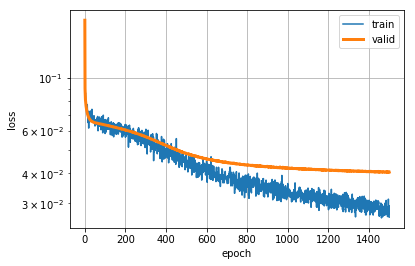

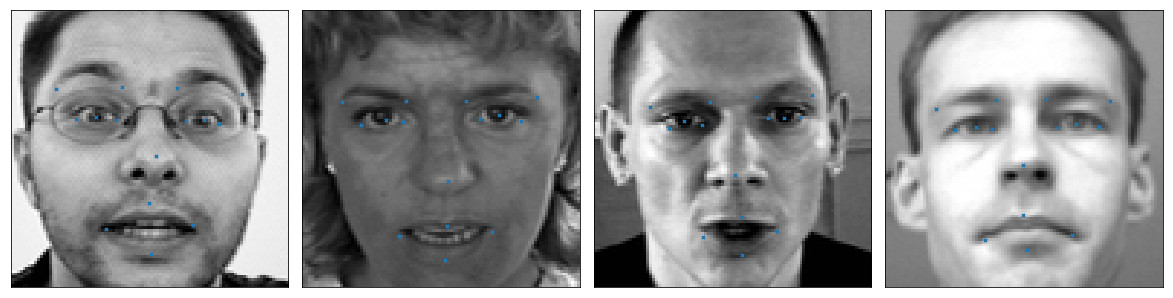

In [32]:
#Base net 2 - Convolutional Neural Network
np.random.seed(1)
graph_base = tf.Graph()
with graph_base.as_default():

    if tensorboard_log:
        now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
        logdir = "{}/run-{}/".format(root_logdir, now)

    # def 
    # is_train = True
    #input data
    X = tf.placeholder(tf.float32,[None,X.shape[1]])
    y = tf.placeholder(tf.float32,[None,y.shape[1]])
    training = tf.placeholder(tf.bool)

    #convert x into 4-D input
    #2nd and 3rd dimension is image width and height, final dimension is number of color channels
    x_image = tf.reshape(X,[-1,96,96,1]) 

    #First convolutional layer
    with tf.variable_scope('conv1'):
        layer_conv1, weights_conv1 = new_conv_relu_layer (input = x_image, 
                                                          filter_size = filter_size1, 
                                                          num_filters = num_filters1, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob1)

    #Second convolutional layer
    with tf.variable_scope('conv2'):
        layer_conv2, weights_conv2 = new_conv_relu_layer (input = layer_conv1, 
                                                          filter_size = filter_size2, 
                                                          num_filters = num_filters2, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob2)

    #Thrid convolutional layer
    with tf.variable_scope('conv3'):
        layer_conv3, weights_conv3 = new_conv_relu_layer (input = layer_conv2, 
                                                          filter_size = filter_size3, 
                                                          num_filters = num_filters3, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob3)    

    #Flatten conv3 output for dense nn layer 1
    layer_flat, num_features = flatten_layer(layer_conv3)

    #Densely connected layer1
    with tf.variable_scope('fc4'):
        layer_fc4 = new_fc_layer(input =layer_flat,
                                num_inputs = num_features,
                                num_outputs = fc_size4,
                                use_relu = True,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob4)

    #Densely connected layer2
    with tf.variable_scope('fc5'):
        layer_fc5 = new_fc_layer(input =layer_fc4,
                                num_inputs = fc_size4,
                                num_outputs = fc_size5,
                                use_relu = True,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob5)    

    #Densely connected output layer
    with tf.variable_scope('fc6'):
        layer_f6 = new_fc_layer(input =layer_fc5,
                                num_inputs = fc_size5,
                                num_outputs = n_outputs,
                                use_relu = False,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob6)       


    #loss function
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(np.square(layer_f6 - y))
        sqrt_loss = tf.sqrt(loss)
        
    #for tensorboard
    with tf.name_scope('summaries'):
        sqrt_loss_summary = tf.summary.scalar('sqrt_loss', sqrt_loss)

        
    # optimizer
    optimizer = optimize_func(learning_rate = learning_rate,momentum = momentum,use_nesterov = True).minimize(loss)

    train_loss_data = np.zeros((n_epochs,2))
    dev_loss_data = np.zeros((n_epochs,2))
    y_pred = np.zeros((x_test.shape[0],y.shape[1]))

    # logger
    if tensorboard_log:
        train_writer = tf.summary.FileWriter(logdir + '/train', tf.get_default_graph())
        dev_writer =  tf.summary.FileWriter(logdir + '/dev')

    
time_start = time.time()
time_1000_start = time.time()

    
with tf.Session(graph=graph_base) as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(n_epochs):
        #print('starting epoch:',epoch)
        
        loss_train,loss_dev = shuffle_run_batch (x_train, y_train, x_dev, y_dev, batch_size, epoch)

        train_loss_data[epoch,:] = epoch,np.sqrt(loss_train)
        dev_loss_data[epoch,:] = epoch,np.sqrt(loss_dev)

        
        if epoch%20 == 0:
            print('Epoch',epoch,'Train loss:%0.3f'%np.sqrt(loss_train),'Dev loss:%0.3f'%np.sqrt(loss_dev),'ratio train/dev:%0.2f'%np.sqrt(loss_train/loss_dev))
        
    time_end = time.time()
    print('Total time taken:',time_end-time_start)
    
    for i in range(int(x_test.shape[0]//batch_size)): #doing predictions in batches
            X_batch = x_test[i*batch_size:(i+1)*batch_size,:]
            y_pred [i*batch_size:(i+1)*batch_size] = sess.run(layer_f6,feed_dict = {X:X_batch, training:False})
    
    if (epoch+1)%200 == 0:
            train_dev_loss = np.hstack((train_loss_data,dev_loss_data))
            with open('net2_basic.csv', 'wb') as fp:
                np.savetxt(fp, train_dev_loss,fmt = '%0.4f')

#Plot a graph of the train vs test loss data and some sample predictions:    
plot_loss (train_loss_data, dev_loss_data)
plot_pred (x_test, y_pred)

#Save the loss output and test predictions to an excel file.
train_dev_loss = np.hstack((train_loss_data,dev_loss_data))
with open('net2_base.csv', 'wb') as fp:
    np.savetxt(fp, train_dev_loss,fmt = '%0.4f')
with open('net2_base_test_pred.csv','wb') as fs:
    np.savetxt(fs,y_pred,fmt = '%0.4f')

if tensorboard_log:
    train_writer.close()
    dev_writer.close()



Helper function to flip the images and the keypoints. Takes one image at a time.

In [77]:
#Helper function to flip the images and the keypoints. Takes one image at a time.
def flip_horizontal(x,y):
    img = x.reshape(96,96)
    img1 = np.zeros(img.shape)
    #print(y.shape[0])
    y1 = y
    #print(y)
    for i in range(img.shape[1]):
        img1[:,95-i] = img[:,i]
        x1 = img1.reshape(9216)
    
    y1[::2] = y1[::2] * -1
    #print(y1)
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25)]
    for a, b in flip_indices:
                y1[a], y1[b] = (y1[b], y1[a])
    #print(y1)
    return x1,y1

Function to create a shuffled batch with data augmentation with horizontal flip

In [78]:
#Function to create a shuffled batch with data augmentation with horizontal flip
np.random.seed(1)
def shuffle_run_batch_data_aug(Xnp, ynp, Xdev, ydev, batch_size, epoch):
    """function takes training and dev data, shuffle the train data and run TF optimizer in batches for a given epoch
    It returns the average loss for training and eval of all the batches ran in the epoch.
    It expects to run with tensorboard."""

     #Data augmentation with horizontal flips
    Xflip = np.zeros(Xnp.shape) #Array to store the horizontally flipped faces
    yflip = np.zeros(ynp.shape)

    for i in range(Xnp.shape[0]):
        Xflip[i],yflip[i] = flip_horizontal(Xnp[i],ynp[i])
        
    shuffle = np.random.permutation(np.arange(Xnp.shape[0])) #shuffle the training data in each epoch
    Xnp, ynp = Xnp[shuffle], ynp[shuffle]
    shuffle1 = np.random.permutation(np.arange(Xnp.shape[0])) #shuffle the training data in each epoch
    Xflip,yflip = Xflip[shuffle1],yflip[shuffle1]

    # initialize variables to hold loss information for each epoch
    #loss_train = 0
    #loss_dev = 0
    batches = Xnp.shape[0]//batch_size


    for i in range(int(batches)): #run through most of the data points in each epoch
        X_batch = np.vstack((Xnp[i*batch_size//2:(i+1)*batch_size//2,:],Xflip[i*batch_size//2:(i+1)*batch_size//2,:]))
        y_batch = np.vstack((ynp[i*batch_size//2:(i+1)*batch_size//2],yflip[i*batch_size//2:(i+1)*batch_size//2]))
        if tensorboard_log:
            if i % 10 == 0:
                train_summary_str = sqrt_loss_summary.eval(feed_dict={X: X_batch, y: y_batch, current_epoch:epoch,training: True})
                dev_summary_str = sqrt_loss_summary.eval(feed_dict={X: Xdev, y: ydev, current_epoch:epoch,training: False})
                step = epoch * batches + i
                train_writer.add_summary(train_summary_str, step)
                dev_writer.add_summary(dev_summary_str, step)

        sess.run(optimizer, feed_dict = {X:X_batch,y:y_batch, training:True})

    

        loss_train = loss.eval(feed_dict = {X:X_batch,y:y_batch,  training:True})            
        loss_dev = loss.eval(feed_dict = {X:Xdev,y:ydev, training:False})

    
    return loss_train, loss_dev

## Convolutional Neural Network(Net 2 architecture) with data augmentation(horizontal flip)

0 Train loss:0.1225 Dev loss:0.1222 ratio train/dev:1.00
20 Train loss:0.0700 Dev loss:0.0694 ratio train/dev:1.01
40 Train loss:0.0654 Dev loss:0.0665 ratio train/dev:0.98
60 Train loss:0.0689 Dev loss:0.0660 ratio train/dev:1.04
80 Train loss:0.0676 Dev loss:0.0655 ratio train/dev:1.03
100 Train loss:0.0669 Dev loss:0.0653 ratio train/dev:1.02
120 Train loss:0.0637 Dev loss:0.0649 ratio train/dev:0.98
140 Train loss:0.0609 Dev loss:0.0645 ratio train/dev:0.94
160 Train loss:0.0685 Dev loss:0.0642 ratio train/dev:1.07
180 Train loss:0.0647 Dev loss:0.0638 ratio train/dev:1.01
200 Train loss:0.0640 Dev loss:0.0635 ratio train/dev:1.01
220 Train loss:0.0647 Dev loss:0.0630 ratio train/dev:1.03
240 Train loss:0.0592 Dev loss:0.0627 ratio train/dev:0.94
260 Train loss:0.0688 Dev loss:0.0623 ratio train/dev:1.10
280 Train loss:0.0597 Dev loss:0.0618 ratio train/dev:0.96
300 Train loss:0.0586 Dev loss:0.0615 ratio train/dev:0.95
320 Train loss:0.0540 Dev loss:0.0610 ratio train/dev:0.89
340

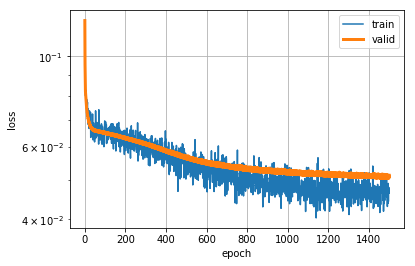

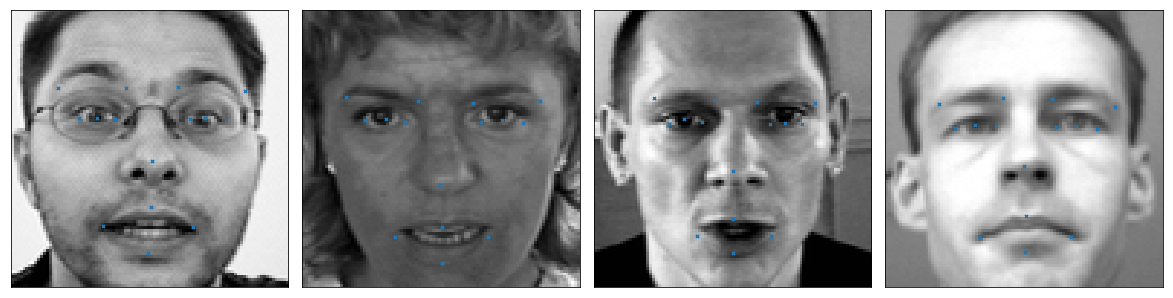

In [79]:
#Convolutional Neural Network with data augmentation(horizontal flip)
np.random.seed(1)
graph_base = tf.Graph()
with graph_base.as_default():

    if tensorboard_log:
        now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
        logdir = "{}/run-{}/".format(root_logdir, now)

    # def 
    # is_train = True
    #input data
    X = tf.placeholder(tf.float32,[None,X.shape[1]])
    y = tf.placeholder(tf.float32,[None,y.shape[1]])
    training = tf.placeholder(tf.bool)

    #convert x into 4-D input
    #2nd and 3rd dimension is image width and height, final dimension is number of color channels
    x_image = tf.reshape(X,[-1,96,96,1]) 

    #First convolutional layer
    with tf.variable_scope('conv1'):
        layer_conv1, weights_conv1 = new_conv_relu_layer (input = x_image, 
                                                          filter_size = filter_size1, 
                                                          num_filters = num_filters1, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob1)

    #Second convolutional layer
    with tf.variable_scope('conv2'):
        layer_conv2, weights_conv2 = new_conv_relu_layer (input = layer_conv1, 
                                                          filter_size = filter_size2, 
                                                          num_filters = num_filters2, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob2)

    #Thrid convolutional layer
    with tf.variable_scope('conv3'):
        layer_conv3, weights_conv3 = new_conv_relu_layer (input = layer_conv2, 
                                                          filter_size = filter_size3, 
                                                          num_filters = num_filters3, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob3)    

    #Flatten conv3 output for dense nn layer 1
    layer_flat, num_features = flatten_layer(layer_conv3)

    #Densely connected layer1
    with tf.variable_scope('fc4'):
        layer_fc4 = new_fc_layer(input =layer_flat,
                                num_inputs = num_features,
                                num_outputs = fc_size4,
                                use_relu = True,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob4)

    #Densely connected layer2
    with tf.variable_scope('fc5'):
        layer_fc5 = new_fc_layer(input =layer_fc4,
                                num_inputs = fc_size4,
                                num_outputs = fc_size5,
                                use_relu = True,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob5)    

    #Densely connected output layer
    with tf.variable_scope('fc6'):
        layer_f6 = new_fc_layer(input =layer_fc5,
                                num_inputs = fc_size5,
                                num_outputs = n_outputs,
                                use_relu = False,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob6)       


    #loss function
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(np.square(layer_f6 - y))
        sqrt_loss = tf.sqrt(loss)
        
    #for tensorboard
    with tf.name_scope('summaries'):
        sqrt_loss_summary = tf.summary.scalar('sqrt_loss', sqrt_loss)

        
    # optimizer
    optimizer = optimize_func(learning_rate = learning_rate,momentum = momentum,use_nesterov = True).minimize(loss)

    train_loss_data = np.zeros((n_epochs,2))
    dev_loss_data = np.zeros((n_epochs,2))
    y_pred = np.zeros((x_test.shape[0],y.shape[1]))

    # logger
    if tensorboard_log:
        train_writer = tf.summary.FileWriter(logdir + '/train', tf.get_default_graph())
        dev_writer =  tf.summary.FileWriter(logdir + '/dev')

    
time_start = time.time()
time_1000_start = time.time()

    
with tf.Session(graph=graph_base) as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(n_epochs):
        #print('starting epoch:',epoch)
        
        loss_train,loss_dev = shuffle_run_batch_data_aug (x_train, y_train, x_dev, y_dev, batch_size, epoch)

        train_loss_data[epoch,:] = epoch,np.sqrt(loss_train)
        dev_loss_data[epoch,:] = epoch,np.sqrt(loss_dev)

        
        if epoch%20 == 0:
            print(epoch,'Train loss:%0.4f'%np.sqrt(loss_train),'Dev loss:%0.4f'%np.sqrt(loss_dev),'ratio train/dev:%0.2f'%np.sqrt(loss_train/loss_dev))
        
    time_end = time.time()
    print('Total time taken:',time_end-time_start)
    
    for i in range(int(x_test.shape[0]//batch_size)): #doing predictions in batches
            X_batch = x_test[i*batch_size:(i+1)*batch_size,:]
            y_pred [i*batch_size:(i+1)*batch_size] = sess.run(layer_f6,feed_dict = {X:X_batch, training:False})

#Plot a graph of the train vs test loss data:
plot_loss (train_loss_data, dev_loss_data)
plot_pred (x_test, y_pred)

#Save the loss output and test predictions to an excel file.
train_dev_loss = np.hstack((train_loss_data,dev_loss_data))
with open('net2_data_aug.csv', 'wb') as fp:
    np.savetxt(fp, train_dev_loss,fmt = '%0.4f')
with open('net2_data_aug_test_pred.csv','wb') as fs:
    np.savetxt(fs,y_pred,fmt = '%0.4f')

if tensorboard_log:
    train_writer.close()
    dev_writer.close()


## CNN with data augmentation and increasing momentum(does not include horizontal flip)

starting
0 Train loss:0.0819 Dev loss:0.0833 ratio train/dev:0.98 momentum:0.9000 learning rate:0.0800
20 Train loss:0.0645 Dev loss:0.0644 ratio train/dev:1.00 momentum:0.9012 learning rate:0.0763
40 Train loss:0.0598 Dev loss:0.0616 ratio train/dev:0.97 momentum:0.9024 learning rate:0.0729
60 Train loss:0.0606 Dev loss:0.0586 ratio train/dev:1.03 momentum:0.9036 learning rate:0.0695
80 Train loss:0.0562 Dev loss:0.0560 ratio train/dev:1.00 momentum:0.9048 learning rate:0.0664
100 Train loss:0.0546 Dev loss:0.0536 ratio train/dev:1.02 momentum:0.9060 learning rate:0.0633
120 Train loss:0.0494 Dev loss:0.0527 ratio train/dev:0.94 momentum:0.9072 learning rate:0.0604
140 Train loss:0.0456 Dev loss:0.0518 ratio train/dev:0.88 momentum:0.9084 learning rate:0.0577
160 Train loss:0.0542 Dev loss:0.0513 ratio train/dev:1.06 momentum:0.9096 learning rate:0.0551
180 Train loss:0.0504 Dev loss:0.0510 ratio train/dev:0.99 momentum:0.9108 learning rate:0.0525
200 Train loss:0.0499 Dev loss:0.0508

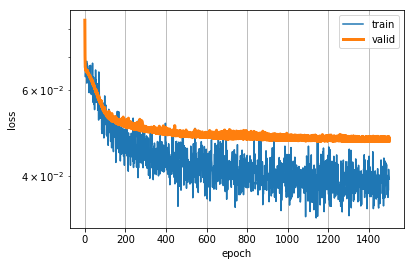

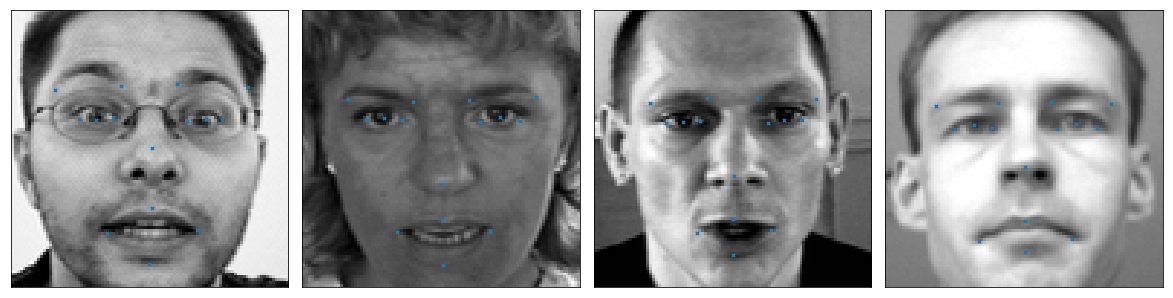

In [80]:

#Tried a few variations. Only one variation is shown here. Output of the rest will be shown in the presentation.

np.random.seed(1)
graph_base = tf.Graph()
with graph_base.as_default():

    if tensorboard_log:
        now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
        logdir = "{}/run-{}/".format(root_logdir, now)

    # def 
    # is_train = True
    #input data
    X = tf.placeholder(tf.float32,[None,X.shape[1]])
    y = tf.placeholder(tf.float32,[None,y.shape[1]])
    training = tf.placeholder(tf.bool)

    #convert x into 4-D input
    #2nd and 3rd dimension is image width and height, final dimension is number of color channels
    x_image = tf.reshape(X,[-1,96,96,1]) 

    #First convolutional layer
    with tf.variable_scope('conv1'):
        layer_conv1, weights_conv1 = new_conv_relu_layer (input = x_image, 
                                                          filter_size = filter_size1, 
                                                          num_filters = num_filters1, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob1)

    #Second convolutional layer
    with tf.variable_scope('conv2'):
        layer_conv2, weights_conv2 = new_conv_relu_layer (input = layer_conv1, 
                                                          filter_size = filter_size2, 
                                                          num_filters = num_filters2, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob2)

    #Thrid convolutional layer
    with tf.variable_scope('conv3'):
        layer_conv3, weights_conv3 = new_conv_relu_layer (input = layer_conv2, 
                                                          filter_size = filter_size3, 
                                                          num_filters = num_filters3, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob3)    

    #Flatten conv3 output for dense nn layer 1
    layer_flat, num_features = flatten_layer(layer_conv3)

    #Densely connected layer1
    with tf.variable_scope('fc4'):
        layer_fc4 = new_fc_layer(input =layer_flat,
                                num_inputs = num_features,
                                num_outputs = fc_size4,
                                use_relu = True,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob4)

    #Densely connected layer2
    with tf.variable_scope('fc5'):
        layer_fc5 = new_fc_layer(input =layer_fc4,
                                num_inputs = fc_size4,
                                num_outputs = fc_size5,
                                use_relu = True,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob5)    

    #Densely connected output layer
    with tf.variable_scope('fc6'):
        layer_f6 = new_fc_layer(input =layer_fc5,
                                num_inputs = fc_size5,
                                num_outputs = n_outputs,
                                use_relu = False,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob6)       


    #loss function
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(np.square(layer_f6 - y))
        sqrt_loss = tf.sqrt(loss)
        
    #for tensorboard
    with tf.name_scope('summaries'):
        sqrt_loss_summary = tf.summary.scalar('sqrt_loss', sqrt_loss)

        
    # optimizer
    current_epoch = tf.Variable(0.0)
    m_min = 0.9
    m_max = 0.99
    momentum = m_min + (m_max-m_min)*current_epoch/n_epochs
    lr_min = 0.1
    lr_max = 0.3
    learning_rate = tf.train.exponential_decay(0.08, current_epoch, decay_steps=n_epochs, decay_rate=0.03)
    optimizer = optimize_func(learning_rate = learning_rate,momentum = momentum,use_nesterov = True).minimize(loss)
    

    train_loss_data = np.zeros((n_epochs,2))
    dev_loss_data = np.zeros((n_epochs,2))
    y_pred = np.zeros((x_test.shape[0],y.shape[1]))

    # logger
    if tensorboard_log:
        train_writer = tf.summary.FileWriter(logdir + '/train', tf.get_default_graph())
        dev_writer =  tf.summary.FileWriter(logdir + '/dev')

    
time_start = time.time()
time_1000_start = time.time()

    
with tf.Session(graph=graph_base) as sess:
    sess.run(tf.global_variables_initializer())
    print('starting') 
    
    for epoch in range(n_epochs):
        loss_train,loss_dev = shuffle_run_batch_data_aug (x_train, y_train, x_dev, y_dev, batch_size, epoch)

        train_loss_data[epoch,:] = epoch,np.sqrt(loss_train)
        dev_loss_data[epoch,:] = epoch,np.sqrt(loss_dev)
        
        if epoch%20 == 0:
            m = momentum.eval(feed_dict = {current_epoch:epoch})
            lr = learning_rate.eval(feed_dict = {current_epoch:epoch})
            print(epoch,'Train loss:%0.4f'%np.sqrt(loss_train),'Dev loss:%0.4f'%np.sqrt(loss_dev),
                  'ratio train/dev:%0.2f'%np.sqrt(loss_train/loss_dev),'momentum:%0.4f'%m,'learning rate:%0.4f'%lr)
            
        if (epoch+1)%200 == 0:
            train_dev_loss = np.hstack((train_loss_data,dev_loss_data))
            with open('net2_data_aug_momentum_lr_change_2.csv', 'wb') as fp:
                np.savetxt(fp, train_dev_loss,fmt = '%0.4f')
            with open('net2_data_aug_momentum_lr_change_2_test_pred.csv','wb') as fs:
                np.savetxt(fs,y_pred,fmt = '%0.4f')
        
    time_end = time.time()
    print('Total time taken:',time_end-time_start)
    
    for i in range(int(x_test.shape[0]//batch_size)): #doing predictions in batches
            X_batch = x_test[i*batch_size:(i+1)*batch_size,:]
            y_pred [i*batch_size:(i+1)*batch_size] = sess.run(layer_f6,feed_dict = {X:X_batch, training:False})

#Plot a graph of the train vs test loss data:
    
plot_loss (train_loss_data, dev_loss_data)
plot_pred (x_test, y_pred)

if tensorboard_log:
    train_writer.close()
    dev_writer.close()

## CNN with Leaky Relu Activation (alpha = 0.05)

0 Train loss:0.1989 Dev loss:0.2000 ratio train/dev:0.99
20 Train loss:0.0727 Dev loss:0.0683 ratio train/dev:1.06
40 Train loss:0.0695 Dev loss:0.0656 ratio train/dev:1.06
60 Train loss:0.0644 Dev loss:0.0649 ratio train/dev:0.99
80 Train loss:0.0609 Dev loss:0.0643 ratio train/dev:0.95
100 Train loss:0.0589 Dev loss:0.0638 ratio train/dev:0.92
120 Train loss:0.0637 Dev loss:0.0631 ratio train/dev:1.01
140 Train loss:0.0652 Dev loss:0.0625 ratio train/dev:1.04
160 Train loss:0.0588 Dev loss:0.0618 ratio train/dev:0.95
180 Train loss:0.0607 Dev loss:0.0611 ratio train/dev:0.99
200 Train loss:0.0563 Dev loss:0.0605 ratio train/dev:0.93
220 Train loss:0.0630 Dev loss:0.0597 ratio train/dev:1.06
240 Train loss:0.0594 Dev loss:0.0588 ratio train/dev:1.01
260 Train loss:0.0527 Dev loss:0.0581 ratio train/dev:0.91
280 Train loss:0.0563 Dev loss:0.0572 ratio train/dev:0.98
300 Train loss:0.0530 Dev loss:0.0561 ratio train/dev:0.94
320 Train loss:0.0544 Dev loss:0.0551 ratio train/dev:0.99
340

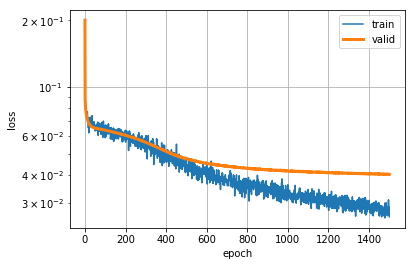

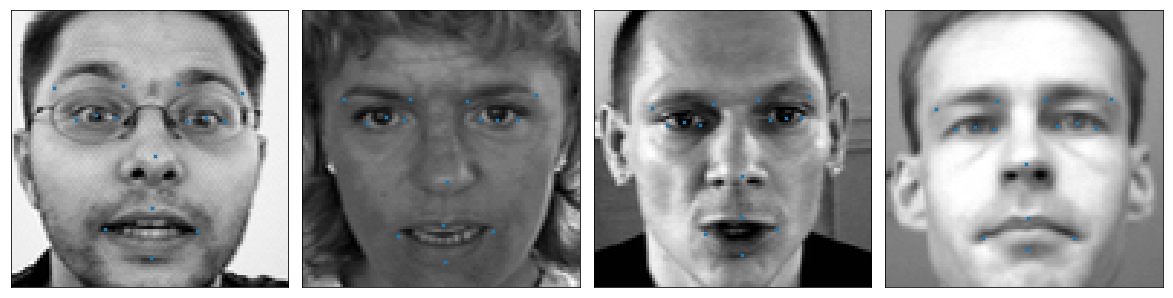

In [86]:

#Note - in order to run this - we have to uncomment the line layer = lrelu(layer) in function new_conv_relu_layer and new_fc_layer
# and comment the line: layer = tf.nn.relu(layer)
np.random.seed(1)
graph_base = tf.Graph()
with graph_base.as_default():

    if tensorboard_log:
        now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
        logdir = "{}/run-{}/".format(root_logdir, now)

    # def 
    # is_train = True
    #input data
    X = tf.placeholder(tf.float32,[None,X.shape[1]])
    y = tf.placeholder(tf.float32,[None,y.shape[1]])
    training = tf.placeholder(tf.bool)

    #convert x into 4-D input
    #2nd and 3rd dimension is image width and height, final dimension is number of color channels
    x_image = tf.reshape(X,[-1,96,96,1]) 

    #First convolutional layer
    with tf.variable_scope('conv1'):
        layer_conv1, weights_conv1 = new_conv_relu_layer (input = x_image, 
                                                          filter_size = filter_size1, 
                                                          num_filters = num_filters1, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob1)

    #Second convolutional layer
    with tf.variable_scope('conv2'):
        layer_conv2, weights_conv2 = new_conv_relu_layer (input = layer_conv1, 
                                                          filter_size = filter_size2, 
                                                          num_filters = num_filters2, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob2)

    #Thrid convolutional layer
    with tf.variable_scope('conv3'):
        layer_conv3, weights_conv3 = new_conv_relu_layer (input = layer_conv2, 
                                                          filter_size = filter_size3, 
                                                          num_filters = num_filters3, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob3)    

    #Flatten conv3 output for dense nn layer 1
    layer_flat, num_features = flatten_layer(layer_conv3)

    #Densely connected layer1
    with tf.variable_scope('fc4'):
        layer_fc4 = new_fc_layer(input =layer_flat,
                                num_inputs = num_features,
                                num_outputs = fc_size4,
                                use_relu = True,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob4)

    #Densely connected layer2
    with tf.variable_scope('fc5'):
        layer_fc5 = new_fc_layer(input =layer_fc4,
                                num_inputs = fc_size4,
                                num_outputs = fc_size5,
                                use_relu = True,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob5)    

    #Densely connected output layer
    with tf.variable_scope('fc6'):
        layer_f6 = new_fc_layer(input =layer_fc5,
                                num_inputs = fc_size5,
                                num_outputs = n_outputs,
                                use_relu = False,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob6)       


    #loss function
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(np.square(layer_f6 - y))
        sqrt_loss = tf.sqrt(loss)
        
    #for tensorboard
    with tf.name_scope('summaries'):
        sqrt_loss_summary = tf.summary.scalar('sqrt_loss', sqrt_loss)

        
    # optimizer
    current_epoch = tf.Variable(0.0)
    momentum = 0.9
    learning_rate = 0.01
    optimizer = optimize_func(learning_rate = learning_rate,momentum = momentum,use_nesterov = True).minimize(loss)

    train_loss_data = np.zeros((n_epochs,2))
    dev_loss_data = np.zeros((n_epochs,2))
    y_pred = np.zeros((x_test.shape[0],y.shape[1]))

    # logger
    if tensorboard_log:
        train_writer = tf.summary.FileWriter(logdir + '/train', tf.get_default_graph())
        dev_writer =  tf.summary.FileWriter(logdir + '/dev')

    
time_start = time.time()
time_1000_start = time.time()

    
with tf.Session(graph=graph_base) as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(n_epochs):
        #print('starting epoch:',epoch)
        
        loss_train,loss_dev = shuffle_run_batch (x_train, y_train, x_dev, y_dev, batch_size, epoch)

        train_loss_data[epoch,:] = epoch,np.sqrt(loss_train)
        dev_loss_data[epoch,:] = epoch,np.sqrt(loss_dev)

        
        if epoch%20 == 0:
            print(epoch,'Train loss:%0.4f'%np.sqrt(loss_train),'Dev loss:%0.4f'%np.sqrt(loss_dev),
                  'ratio train/dev:%0.2f'%np.sqrt(loss_train/loss_dev))
        
        if (epoch+1)%200 == 0:
            train_dev_loss = np.hstack((train_loss_data,dev_loss_data))
            with open('net2_basic_leaky_relu_momentum3.csv', 'wb') as fp:
                np.savetxt(fp, train_dev_loss,fmt = '%0.4f')
                
    time_end = time.time()
    print('Total time taken:',time_end-time_start)
    
    for i in range(int(x_test.shape[0]//batch_size)): #doing predictions in batches
            X_batch = x_test[i*batch_size:(i+1)*batch_size,:]
            y_pred [i*batch_size:(i+1)*batch_size] = sess.run(layer_f6,feed_dict = {X:X_batch, training:False})
            #Save the loss output and test predictions to an excel file.
    
    train_dev_loss = np.hstack((train_loss_data,dev_loss_data))
    with open('net2_basic_leaky_relu_momentum3.csv', 'wb') as fp:
                np.savetxt(fp, train_dev_loss,fmt = '%0.4f')
    with open('net2_basic_leaky_relu_momentum3_test_pred','wb') as fs:
        np.savetxt(fs,y_pred,fmt = '%0.4f')

#Plot a graph of the train vs test loss data:    
plot_loss (train_loss_data, dev_loss_data)
plot_pred (x_test, y_pred)

if tensorboard_log:
    train_writer.close()
    dev_writer.close()


Helper Function to create CNN with different filter sizes as parameters

In [15]:
#Function to create CNN with filter sizes as parameters
def createCNN(input,i,filter_size1=3,filter_size2=2,filter_size3=2):
    np.random.seed(1)
    #First convolutional layer
    with tf.variable_scope('conv1'+str(i)):
        layer_conv1, weights_conv1 = new_conv_relu_layer (input = x_image, 
                                                          filter_size = filter_size1, 
                                                          num_filters = num_filters1, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob1)

    #Second convolutional layer
    with tf.variable_scope('conv2'+str(i)):
        layer_conv2, weights_conv2 = new_conv_relu_layer (input = layer_conv1, 
                                                          filter_size = filter_size2, 
                                                          num_filters = num_filters2, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob2)

    #Thrid convolutional layer
    with tf.variable_scope('conv3'+str(i)):
        layer_conv3, weights_conv3 = new_conv_relu_layer (input = layer_conv2, 
                                                          filter_size = filter_size3, 
                                                          num_filters = num_filters3, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob3)    

    #Flatten conv3 output for dense nn layer 1
    layer_flat, num_features = flatten_layer(layer_conv3)

    #Densely connected layer1
    with tf.variable_scope('fc4'+str(i)):
        layer_fc4 = new_fc_layer(input =layer_flat,
                                num_inputs = num_features,
                                num_outputs = fc_size4,
                                use_relu = True,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob4)

    #Densely connected layer2
    with tf.variable_scope('fc5'+str(i)):
        layer_fc5 = new_fc_layer(input =layer_fc4,
                                num_inputs = fc_size4,
                                num_outputs = fc_size5,
                                use_relu = True,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob5)    

    #Densely connected output layer
    with tf.variable_scope('fc6'+str(i)):
        layer_f6 = new_fc_layer(input =layer_fc5,
                                num_inputs = fc_size5,
                                num_outputs = n_outputs,
                                use_relu = False,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob6) 
    return layer_f6

## Trying different CNN filter sizes.
Filter sizes (convolution layer1,2,3) of (3,2,2),(8,4,2),(20,10,2),(2,4,8),(4,12,2)
Concept is to try different filter sizers, and also different ordering of the filter sizes

number of filter variations: 5
convolution filters 3 2 2
starting
0 Train loss:0.0836 Dev loss:0.0807 ratio train/dev:1.04 momentum:0.9000 learning rate:0.0600
10 Train loss:0.0681 Dev loss:0.0654 ratio train/dev:1.04 momentum:0.9036 learning rate:0.0522
20 Train loss:0.0680 Dev loss:0.0644 ratio train/dev:1.06 momentum:0.9072 learning rate:0.0454
30 Train loss:0.0684 Dev loss:0.0627 ratio train/dev:1.09 momentum:0.9108 learning rate:0.0395
40 Train loss:0.0630 Dev loss:0.0607 ratio train/dev:1.04 momentum:0.9143 learning rate:0.0343
50 Train loss:0.0557 Dev loss:0.0583 ratio train/dev:0.96 momentum:0.9179 learning rate:0.0298
60 Train loss:0.0545 Dev loss:0.0555 ratio train/dev:0.98 momentum:0.9215 learning rate:0.0259
70 Train loss:0.0518 Dev loss:0.0523 ratio train/dev:0.99 momentum:0.9251 learning rate:0.0226
80 Train loss:0.0441 Dev loss:0.0497 ratio train/dev:0.89 momentum:0.9287 learning rate:0.0196
90 Train loss:0.0468 Dev loss:0.0478 ratio train/dev:0.98 momentum:0.9323 learni

40 Train loss:0.0635 Dev loss:0.0613 ratio train/dev:1.04 momentum:0.9143 learning rate:0.0343
50 Train loss:0.0561 Dev loss:0.0590 ratio train/dev:0.95 momentum:0.9179 learning rate:0.0298
60 Train loss:0.0545 Dev loss:0.0562 ratio train/dev:0.97 momentum:0.9215 learning rate:0.0259
70 Train loss:0.0520 Dev loss:0.0529 ratio train/dev:0.98 momentum:0.9251 learning rate:0.0226
80 Train loss:0.0438 Dev loss:0.0502 ratio train/dev:0.87 momentum:0.9287 learning rate:0.0196
90 Train loss:0.0501 Dev loss:0.0529 ratio train/dev:0.95 momentum:0.9323 learning rate:0.0171
100 Train loss:0.0376 Dev loss:0.0465 ratio train/dev:0.81 momentum:0.9359 learning rate:0.0148
110 Train loss:0.0382 Dev loss:0.0454 ratio train/dev:0.84 momentum:0.9394 learning rate:0.0129
120 Train loss:0.0391 Dev loss:0.0445 ratio train/dev:0.88 momentum:0.9430 learning rate:0.0112
130 Train loss:0.0391 Dev loss:0.0439 ratio train/dev:0.89 momentum:0.9466 learning rate:0.0098
140 Train loss:0.0380 Dev loss:0.0429 ratio tr

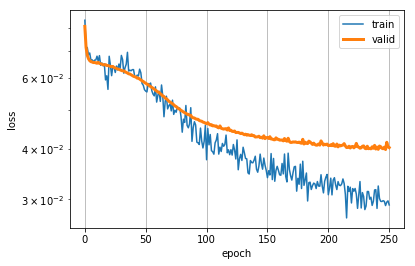

In [16]:
#trying different CNN filter sizes.
#Trying filter sizes (convolution layer1,2,3) of (3,2,2),(8,4,2),(20,10,2),(2,4,8),(4,12,2)
#Concept is to try different filter sizers, and also different ordering of the filter sizes
graph_base = tf.Graph()
n_epochs = 251 #Using fewer epochs to do coarse testing of several options. Should test with around 300-400 epochs
with graph_base.as_default():

    if tensorboard_log:
        now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
        logdir = "{}/run-{}/".format(root_logdir, now)

    # def 
    # is_train = True
    #input data
    X = tf.placeholder(tf.float32,[None,X.shape[1]])
    y = tf.placeholder(tf.float32,[None,y.shape[1]])
    training = tf.placeholder(tf.bool)

    #convert x into 4-D input
    #2nd and 3rd dimension is image width and height, final dimension is number of color channels
    x_image = tf.reshape(X,[-1,96,96,1])
    
    best_loss = 0.2
    best_filter = np.array((3,2,2))
    filters = np.array(((3,2,2),(8,4,2),(20,10,2),(2,4,8),(4,12,2)))
    print('number of filter variations:',filters.shape[0])
    train_loss_data = np.zeros((n_epochs,filters.shape[0]+1))
    dev_loss_data = np.zeros((n_epochs,filters.shape[0]+1))
    
    for i in range(filters.shape[0]):
       
        filter_size1 = filters[i,0]         
        filter_size2 = filters[i,1]         
        filter_size3 = filters[i,2]  
        print('convolution filters',filter_size1,filter_size2,filter_size3)

        layer_f6 = createCNN(x_image,i,filter_size1,filter_size2,filter_size3)
        
        #loss function
        with tf.name_scope('loss'):
            loss = tf.reduce_mean(np.square(layer_f6 - y))
            sqrt_loss = tf.sqrt(loss)

        #for tensorboard
        with tf.name_scope('summaries'):
            sqrt_loss_summary = tf.summary.scalar('sqrt_loss', sqrt_loss)


        # optimizer
        current_epoch = tf.Variable(0.0)
        m_min = 0.9
        m_max = 0.99
        momentum = m_min + (m_max-m_min)*current_epoch/n_epochs
        lr_min = 0.1
        lr_max = 0.3
        #Note set initial learning rate to 0.06
        learning_rate = tf.train.exponential_decay(0.06, current_epoch, decay_steps=n_epochs, decay_rate=0.03)
        optimizer = optimize_func(learning_rate = learning_rate,momentum = momentum,use_nesterov = True).minimize(loss)

        y_pred = np.zeros((x_test.shape[0],y.shape[1]))

        # logger
        if tensorboard_log:
            train_writer = tf.summary.FileWriter(logdir + '/train', tf.get_default_graph())
            dev_writer =  tf.summary.FileWriter(logdir + '/dev')


        time_start = time.time()
        time_1000_start = time.time()


        with tf.Session(graph=graph_base) as sess:
            sess.run(tf.global_variables_initializer())
            print('starting') 

            for epoch in range(n_epochs):

                loss_train,loss_dev = shuffle_run_batch(x_train, y_train, x_dev, y_dev, batch_size, epoch)

                train_loss_data[epoch,0] = epoch
                dev_loss_data[epoch,0] = epoch
                train_loss_data[epoch,i+1] = np.sqrt(loss_train)
                dev_loss_data[epoch,i+1] = np.sqrt(loss_dev)

                if epoch%10 == 0:
                    m = momentum.eval(feed_dict = {current_epoch:epoch})
                    lr = learning_rate.eval(feed_dict = {current_epoch:epoch})
                    print(epoch,'Train loss:%0.4f'%np.sqrt(loss_train),'Dev loss:%0.4f'%np.sqrt(loss_dev),
                          'ratio train/dev:%0.2f'%np.sqrt(loss_train/loss_dev),'momentum:%0.4f'%m,'learning rate:%0.4f'%lr)
                    
            if loss_dev < best_loss:
                best_loss = loss_dev
                best_filter = np.array((filter_size1,filter_size2,filter_size3))
                print('best filter:',best_filter.shape,best_filter)

            time_end = time.time()
            print('Total time taken for filter %d:'%i,time_end-time_start)
    
            for i in range(int(x_test.shape[0]//batch_size)): #doing predictions in batches
                    X_batch = x_test[i*batch_size:(i+1)*batch_size,:]
                    y_pred [i*batch_size:(i+1)*batch_size] = sess.run(layer_f6,feed_dict = {X:X_batch, training:False})
                    
        
    train_dev_loss = np.hstack((train_loss_data,dev_loss_data))
    with open('net2_cnn_filter_sizes2.csv', 'wb') as fp:
        np.savetxt(fp, train_dev_loss,fmt = '%0.4f')
    
    #Plot a graph of the train vs test loss data:
    plot_loss(train_loss_data, dev_loss_data) #need to figure a way to plot all the losses for all variations

    if tensorboard_log:
        train_writer.close()
        dev_writer.close()

# Individual Facial Parts Models

## Individual model settings

On examining the number of datapoints available for each feature, individual models are made by grouping similar features based on number of data points availabe. the main idea being to maximize use of data. Below is the reasoning behind combining different labels.

1. First I considered putting all eye data into one model, but as we can see above that left_eye_center_x, left_eye_center_y, right_eye_center_x , right_eye_center_y have more than 7000 data points while the remining
eye data points only have 2267 - 2271 data points. So eye data points have been split into two models namely eye center and eye corner.
left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036

#### Facial_group_models - Thirty keypoints have been grouped in six types to create specialized models
#### These specialized models are eye_center, eye_corners, nose_tip, mouth_corner_top, mouth_bottom and eyebrow.

Net 2 as baseline and starting point for net 3
Adds functionality to save the weights so they can be used to initialize the individual models in net3

starting
0 Train loss:0.1665 Dev loss:0.1067 ratio train/dev:1.56 momentum:0.9000 learning rate:0.0300
20 Train loss:0.0779 Dev loss:0.0666 ratio train/dev:1.17 momentum:0.9012 learning rate:0.0286
40 Train loss:0.0760 Dev loss:0.0660 ratio train/dev:1.15 momentum:0.9024 learning rate:0.0273
60 Train loss:0.0702 Dev loss:0.0656 ratio train/dev:1.07 momentum:0.9036 learning rate:0.0261
80 Train loss:0.0657 Dev loss:0.0652 ratio train/dev:1.01 momentum:0.9048 learning rate:0.0249
100 Train loss:0.0633 Dev loss:0.0649 ratio train/dev:0.98 momentum:0.9060 learning rate:0.0238
120 Train loss:0.0678 Dev loss:0.0644 ratio train/dev:1.05 momentum:0.9072 learning rate:0.0227
140 Train loss:0.0690 Dev loss:0.0640 ratio train/dev:1.08 momentum:0.9084 learning rate:0.0216
160 Train loss:0.0640 Dev loss:0.0635 ratio train/dev:1.01 momentum:0.9096 learning rate:0.0206
180 Train loss:0.0653 Dev loss:0.0630 ratio train/dev:1.04 momentum:0.9108 learning rate:0.0197
200 Train loss:0.0620 Dev loss:0.0624

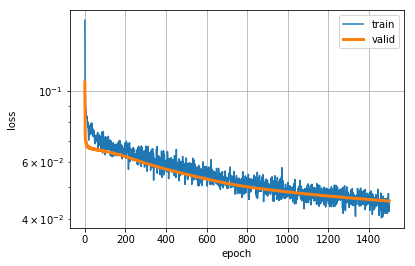

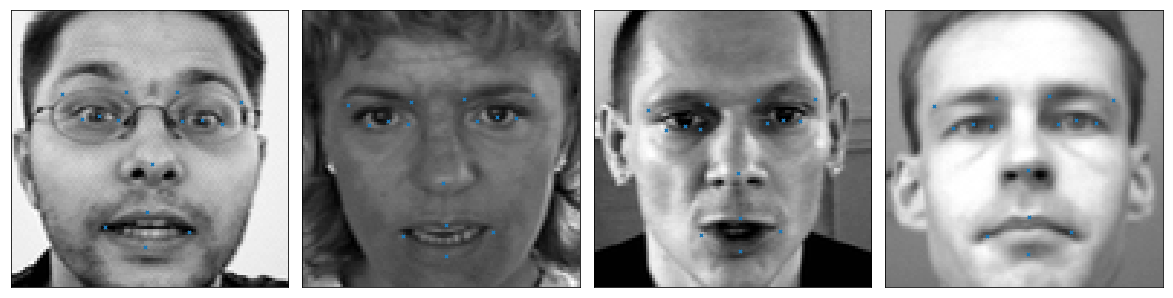

In [64]:
#Net 2 as baseline and starting point for net 3
np.random.seed(1)
graph_base = tf.Graph()
n_epochs = 1501 # resetting n_epochs back to max after testing different filter sizes. needs to be consistent for this and net 3.
#changing keep_prob values
dropout_keep_prob1 = 1.0
dropout_keep_prob2 = 1.0
dropout_keep_prob3 = 1.0
dropout_keep_prob4 = 0.7
dropout_keep_prob5 = 0.7
#Setting filters to best value from trying with net 2
num_filters1 = 3
num_filters2 = 2
num_filters3 = 2

with graph_base.as_default():

    if tensorboard_log:
        now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
        logdir = "{}/run-{}/".format(root_logdir, now)

    # def 
    # is_train = True
    #input data
    X = tf.placeholder(tf.float32,[None,X.shape[1]])
    y = tf.placeholder(tf.float32,[None,y.shape[1]])
    training = tf.placeholder(tf.bool)
    
    current_epoch = tf.Variable(0)

    #convert x into 4-D input
    #2nd and 3rd dimension is image width and height, final dimension is number of color channels
    x_image = tf.reshape(X,[-1,96,96,1]) 

    #First convolutional layer
    with tf.variable_scope('conv1'):
        layer_conv1, weights_conv1 = new_conv_relu_layer (input = x_image, 
                                                          filter_size = filter_size1, 
                                                          num_filters = num_filters1, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob1)

    #Second convolutional layer
    with tf.variable_scope('conv2'):
        layer_conv2, weights_conv2 = new_conv_relu_layer (input = layer_conv1, 
                                                          filter_size = filter_size2, 
                                                          num_filters = num_filters2, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob2)

    #Thrid convolutional layer
    with tf.variable_scope('conv3'):
        layer_conv3, weights_conv3 = new_conv_relu_layer (input = layer_conv2, 
                                                          filter_size = filter_size3, 
                                                          num_filters = num_filters3, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob3)    

    #Flatten conv3 output for dense nn layer 1
    layer_flat, num_features = flatten_layer(layer_conv3)

    #Densely connected layer1
    with tf.variable_scope('fc4'):
        layer_fc4 = new_fc_layer(input =layer_flat,
                                num_inputs = num_features,
                                num_outputs = fc_size4,
                                use_relu = True,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob4)

    #Densely connected layer2
    with tf.variable_scope('fc5'):
        layer_fc5 = new_fc_layer(input =layer_fc4,
                                num_inputs = fc_size4,
                                num_outputs = fc_size5,
                                use_relu = True,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob5)    

    #Densely connected output layer
    with tf.variable_scope('fc6'):
        layer_f6 = new_fc_layer(input =layer_fc5,
                                num_inputs = fc_size5,
                                num_outputs = n_outputs,
                                use_relu = False,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob6)       


    #loss function
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(np.square(layer_f6 - y))
        sqrt_loss = tf.sqrt(loss)
        
    #for tensorboard
    with tf.name_scope('summaries'):
        sqrt_loss_summary = tf.summary.scalar('sqrt_loss', sqrt_loss)

        
    # optimizer
    current_epoch = tf.Variable(0.0)
    m_min = 0.9
    m_max = 0.99
    momentum = m_min + (m_max-m_min)*current_epoch/n_epochs
    lr_min = 0.01
    lr_max = 0.03
    learning_rate = tf.train.exponential_decay(0.03, current_epoch, decay_steps=n_epochs, decay_rate=0.03)
    optimizer = optimize_func(learning_rate = learning_rate,momentum = momentum,use_nesterov = True).minimize(loss)

    train_loss_data = np.zeros((n_epochs,2))
    dev_loss_data = np.zeros((n_epochs,2))
    y_pred = np.zeros((x_test.shape[0],y.shape[1]))

    # logger
    if tensorboard_log:
        train_writer = tf.summary.FileWriter(logdir + '/train', tf.get_default_graph())
        dev_writer =  tf.summary.FileWriter(logdir + '/dev')

    
time_start = time.time()
time_1000_start = time.time()

    
with tf.Session(graph=graph_base) as sess:
    sess.run(tf.global_variables_initializer())
    
    #for saving model 
    saver = tf.train.Saver()
    
    print('starting')
    
    for epoch in range(n_epochs):
        #print('starting epoch:',epoch)
        
        loss_train,loss_dev = shuffle_run_batch(x_train, y_train, x_dev, y_dev, batch_size, epoch)

        train_loss_data[epoch,:] = epoch,np.sqrt(loss_train)
        dev_loss_data[epoch,:] = epoch,np.sqrt(loss_dev)

        
        if epoch%20 == 0:
            m = momentum.eval(feed_dict = {current_epoch:epoch})
            lr = learning_rate.eval(feed_dict = {current_epoch:epoch})
            print(epoch,'Train loss:%0.4f'%np.sqrt(loss_train),'Dev loss:%0.4f'%np.sqrt(loss_dev),
                          'ratio train/dev:%0.2f'%np.sqrt(loss_train/loss_dev),'momentum:%0.4f'%m,'learning rate:%0.4f'%lr)
                    
    time_end = time.time()
    print('Total time taken:',time_end-time_start)
    
    #Code to save models for future use
    #please give any unique name you want to give to the model for testing various paramaters.
    #It wil get appended to "basic_conv_net"
    unique_name = ""
    model_name = "basic_conv_net_" + unique_name
    model_path =  FROOT + "/models/"+ model_name + "/model.ckpt"
    train_history_path = FROOT + "/models/" + model_name + "/train_history"
    save_path = saver.save(sess, model_path)
    print("Model file: " + save_path)
    np.savez(train_history_path, train_loss_history = train_loss_data, valid_loss_history = dev_loss_data)
    print("Train history file: " + train_history_path)
    
    for i in range(int(x_test.shape[0]//batch_size)): #doing predictions in batches
            X_batch = x_test[i*batch_size:(i+1)*batch_size,:]
            y_pred [i*batch_size:(i+1)*batch_size] = sess.run(layer_f6,feed_dict = {X:X_batch, training:False})
    print('done')

#Plot a graph of the train vs test loss data:
    

plot_loss (train_loss_data, dev_loss_data)
train_dev_loss = np.hstack((train_loss_data,dev_loss_data))
with open('net2_baseline_for_net3.csv', 'wb') as fp:
    np.savetxt(fp, train_dev_loss,fmt = '%0.4f')
with open('net2_baseline_for_net3_test_pred.csv','wb') as fs:
        np.savetxt(fs,y_pred,fmt = '%0.4f')

if tensorboard_log:
    train_writer.close()
    dev_writer.close()

plot_pred (x_test, y_pred)


In [33]:
#Individual Facial Keypoints models
#Important to keep the same input as the baseline net 2 being used as starting point for weights
n_epochs = 1501
# dropout_keep_prob1 = 0.9
# dropout_keep_prob2 = 0.8
# dropout_keep_prob3 = 0.8
# dropout_keep_prob4 = 0.7

In [65]:
#Uncomment the dict to run a particular model
facial_group_labels = [
   
    dict(
        name = "mouth_corner_top",
        columns = (
            'mouth_left_corner_x', 'mouth_left_corner_y',
            'mouth_right_corner_x', 'mouth_right_corner_y',
            'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
            )),
     
     dict(
         name = "nose_tip",
         columns = (
             'nose_tip_x', 'nose_tip_y',
             )),

    dict(
        name = "mouth_bottom",
        columns = (
            'mouth_center_bottom_lip_x',
            'mouth_center_bottom_lip_y',
            )),

    dict(
        name = "eye_corner",
        columns = (
            'left_eye_inner_corner_x', 'left_eye_inner_corner_y',
            'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
            'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
            'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
            )),

    dict(
        name = "eyebrow",
        columns = (
            'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
            'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
            'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
            'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
            )),
    
     dict(
        name = "eye_center",
        columns = (
            'left_eye_center_x', 'left_eye_center_y',
            'right_eye_center_x', 'right_eye_center_y',
            )),
    ]

In [66]:
def train_individual_model(facial_model_label):
    
    np.random.seed(1)
    graph_base = tf.Graph()
    
    X, y = load(cols = facial_model_label['columns'])
    num_keypoints = y.shape[1]
    
    
    
    np.random.seed(0)
    dev_size = 0.2
    #setting aside a 20% sample for validation

    x_train, x_dev, y_train, y_dev = train_test_split(X, y, test_size = dev_size)

    x_test, _ = load(test=True)

    print('Training data split into train and dev data')
    print("x_train.shape = = {}; x_train.min == {:.3f}; x_train.max == {:.3f}".format(x_train.shape, x_train.min(),x_train.max()))
    print("y_train.shape = = {}; y_train.min == {:.3f}; y_train.max == {:.3f}".format(y_train.shape, y_train.min(),y_train.max()))
    print("x_dev.shape = = {}; x_dev.min == {:.3f}; x_dev.max == {:.3f}".format(x_dev.shape, x_dev.min(),x_dev.max()))
    print("y_dev.shape = = {}; y_dev.min == {:.3f}; y_dev.max == {:.3f}".format(y_dev.shape, y_dev.min(),y_dev.max()))
    
    with graph_base.as_default():

        if tensorboard_log:
            now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
            logdir = "{}/run-{}/".format(root_logdir, now)

    
        X = tf.placeholder(tf.float32,[None,X.shape[1]])
        y = tf.placeholder(tf.float32,[None,y.shape[1]])
        training = tf.placeholder(tf.bool)
        current_epoch = tf.Variable(0)  # count the number of epochs
    
        #convert x into 4-D input
        #2nd and 3rd dimension is image width and height, final dimension is number of color channels
        x_image = tf.reshape(X,[-1,96,96,1]) 
    
        

        #First convolutional layer
        with tf.variable_scope('conv1'):
            layer_conv1, weights_conv1 = new_conv_relu_layer (input = x_image, 
                                                          filter_size = filter_size1, 
                                                          num_filters = num_filters1, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob1)

        #Second convolutional layer
        with tf.variable_scope('conv2'):
            layer_conv2, weights_conv2 = new_conv_relu_layer (input = layer_conv1, 
                                                          filter_size = filter_size2, 
                                                          num_filters = num_filters2, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob2)

        #Thrid convolutional layer
        with tf.variable_scope('conv3'):
            layer_conv3, weights_conv3 = new_conv_relu_layer (input = layer_conv2, 
                                                          filter_size = filter_size3, 
                                                          num_filters = num_filters3, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob3)    

        #Flatten conv3 output for dense nn layer 1
        layer_flat, num_features = flatten_layer(layer_conv3)

        #Densely connected layer1
        with tf.variable_scope('fc4'):
            layer_fc4 = new_fc_layer(input =layer_flat,
                                num_inputs = num_features,
                                num_outputs = fc_size4,
                                use_relu = True,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob4)

        #Densely connected layer2
        with tf.variable_scope('fc5'):
            layer_fc5 = new_fc_layer(input =layer_fc4,
                                num_inputs = fc_size4,
                                num_outputs = fc_size5,
                                use_relu = True,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob5)    

        #Densely connected output layer
        with tf.variable_scope('fc6'):
            layer_f6 = new_fc_layer(input =layer_fc5,
                                num_inputs = fc_size5,
                                num_outputs = num_keypoints,
                                use_relu = False,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob6)       


        #loss function
        with tf.name_scope('loss'):
            loss = tf.reduce_mean(np.square(layer_f6 - y))
            sqrt_loss = tf.sqrt(loss)
        
        #for tensorboard
        with tf.name_scope('summaries'):
            sqrt_loss_summary = tf.summary.scalar('sqrt_loss', sqrt_loss)
    
        # optimizer
        #making changes to learning rate and momentum for individual models
        # learning rate decay. - Idea is to start with high learning rate to speed up but decrease as we get closer to 
        #the local optimum so that we don't surpass it.
        learning_rate = tf.train.exponential_decay(0.03, current_epoch, decay_steps = n_epochs, decay_rate = 0.03)
        momentum = 0.9 + (0.99 - 0.9) * (current_epoch / n_epochs)
        optimizer = optimize_func(learning_rate = learning_rate,momentum = momentum,use_nesterov = True).minimize(loss)

        train_loss_data = np.zeros((n_epochs,2))
        dev_loss_data = np.zeros((n_epochs,2))
        y_pred = np.zeros((x_dev.shape[0],y.shape[1]))

        # logger
        if tensorboard_log:
            train_writer = tf.summary.FileWriter(logdir + '/train', tf.get_default_graph())
            dev_writer =  tf.summary.FileWriter(logdir + '/dev')

    
    time_start = time.time()
    time_1000_start = time.time()

    
    with tf.Session(graph=graph_base) as sess:
        sess.run(tf.global_variables_initializer())
    
        #for saving model 
        saver = tf.train.Saver()
        
        #initializing weights from a previous session 
        initialising_model = "basic_conv_net_"
        print(" RESTORING SESSION FOR WEIGHTS INITIALIZATION")
        # Exclude output layer weights from variables we will restore
        variables_to_restore = [v for v in tf.global_variables() if "fc6" not in v.op.name]
        # Replace variables scope with that of the current model
        loader = tf.train.Saver({v.op.name.replace(facial_model_label['name'], initialising_model): v for v in variables_to_restore})
        load_path = FROOT + "/models/" + initialising_model + "/model.ckpt"
        loader.restore(sess, load_path)
        print(" Model loaded from: " + load_path)
    
        for epoch in range(n_epochs):
        #print('starting epoch:',epoch)
            current_epoch = epoch
            shuffle = np.random.permutation(np.arange(x_train.shape[0])) #shuffle the training data in each epoch
            x_train, y_train = x_train[shuffle], y_train[shuffle]

            # initialize variables to hold loss information for each epoch
    
            batches = x_train.shape[0]//batch_size

            
            
            for i in range(int(batches)): #run through most of the data points in each epoch
        
                X_batch,y_batch = x_train[i*batch_size:(i+1)*batch_size,:], y_train[i*batch_size:(i+1)*batch_size]
                sess.run(optimizer, feed_dict = {X:X_batch,y:y_batch, training:True})
        
                if tensorboard_log:
                    if i % 10 == 0:
                        train_summary_str = sqrt_loss_summary.eval(feed_dict={X: X_batch, y: y_batch, training: True})
                        dev_summary_str = sqrt_loss_summary.eval(feed_dict={X: Xdev, y: ydev, training: False})
                        step = epoch * batches + i
                        train_writer.add_summary(train_summary_str, step)
                        dev_writer.add_summary(dev_summary_str, step)

            loss_train = loss.eval(feed_dict = {X:X_batch,y:y_batch,  training:True})            
            loss_dev = loss.eval(feed_dict = {X:x_dev,y:y_dev, training:False})
            train_loss_data[epoch,:] = epoch,np.sqrt(loss_train)
            dev_loss_data[epoch,:] = epoch,np.sqrt(loss_dev)

            if epoch%20 == 0:
                print(epoch,'Train loss:%0.3f'%np.sqrt(loss_train),'Dev loss:%0.3f'%np.sqrt(loss_dev),'ratio train/dev:%0.2f'%np.sqrt(loss_train/loss_dev))
        
        time_end = time.time()
        print('Total time taken:',time_end-time_start)
    
        # Save model weights for future use.
        #please give any unique name you want to give to the model for testing various paramaters.
        #It wil get appended to ""basic_conv_net"
        model_name = "ind_model_" + facial_model_label['name'] + "_"
        model_path =  FROOT + "/models/"+ model_name + "/model.ckpt"
        train_history_path = FROOT + "/models/" + model_name + "/train_history"
        save_path = saver.save(sess, model_path)
        print("Model file: " + save_path)
        np.savez(train_history_path, train_loss_history = train_loss_data, valid_loss_history = dev_loss_data)
        print("Train history file: " + train_history_path)
    
        for i in range(int(x_dev.shape[0]//batch_size)): #doing predictions in batches
            X_batch = x_dev[i*batch_size:(i+1)*batch_size,:]
            y_pred [i*batch_size:(i+1)*batch_size] = sess.run(layer_f6,feed_dict = {X:X_batch, training:False})

    #Plot a graph of the train vs dev loss data:
    
    #plt.figure()
    plot_loss (train_loss_data, dev_loss_data)
    print("\n")
    plot_pred (x_dev, y_pred)
    print("\n")
    if tensorboard_log:
        train_writer.close()
        dev_writer.close()

Count of observations in training data by features
mouth_left_corner_x       2269
mouth_left_corner_y       2269
mouth_right_corner_x      2270
mouth_right_corner_y      2270
mouth_center_top_lip_x    2275
mouth_center_top_lip_y    2275
Image                     7049
dtype: int64
done
Count of observations in training data by features
ImageId    1783
Image      1783
dtype: int64
done
Training data split into train and dev data
x_train.shape = = (1808, 9216); x_train.min == 0.000; x_train.max == 1.000
y_train.shape = = (1808, 6); y_train.min == -0.942; y_train.max == 0.990
x_dev.shape = = (452, 9216); x_dev.min == 0.000; x_dev.max == 1.000
y_dev.shape = = (452, 6); y_dev.min == -0.953; y_dev.max == 0.961
 RESTORING SESSION FOR WEIGHTS INITIALIZATION
INFO:tensorflow:Restoring parameters from /home/ubuntu/notebooks/models/basic_conv_net_/model.ckpt
 Model loaded from: /home/ubuntu/notebooks/models/basic_conv_net_/model.ckpt
0 Train loss:0.128 Dev loss:0.127 ratio train/dev:1.01
20 Train l

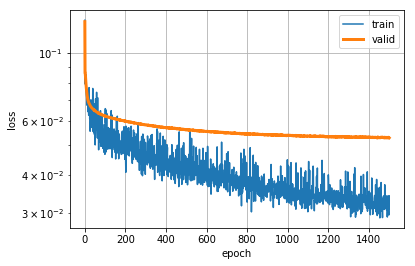





Count of observations in training data by features
nose_tip_x    7049
nose_tip_y    7049
Image         7049
dtype: int64
done
Count of observations in training data by features
ImageId    1783
Image      1783
dtype: int64
done
Training data split into train and dev data
x_train.shape = = (5639, 9216); x_train.min == 0.000; x_train.max == 1.000
y_train.shape = = (5639, 2); y_train.min == -0.730; y_train.max == 0.955
x_dev.shape = = (1410, 9216); x_dev.min == 0.000; x_dev.max == 1.000
y_dev.shape = = (1410, 2); y_dev.min == -0.682; y_dev.max == 0.999
 RESTORING SESSION FOR WEIGHTS INITIALIZATION
INFO:tensorflow:Restoring parameters from /home/ubuntu/notebooks/models/basic_conv_net_/model.ckpt
 Model loaded from: /home/ubuntu/notebooks/models/basic_conv_net_/model.ckpt
0 Train loss:0.108 Dev loss:0.095 ratio train/dev:1.15
20 Train loss:0.086 Dev loss:0.076 ratio train/dev:1.13
40 Train loss:0.095 Dev loss:0.073 ratio train/dev:1.31
60 Train loss:0.067 Dev loss:0.071 ratio train/dev:0

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_base.py:1376: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  'yscale=%s' % (xscale, yscale))


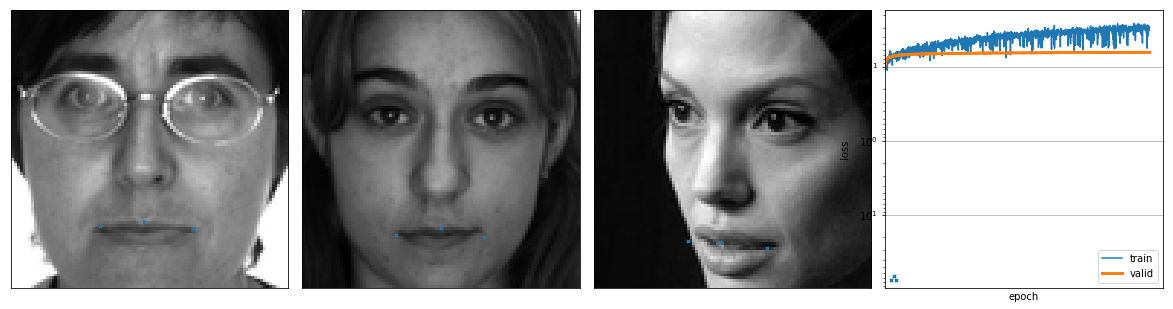





Count of observations in training data by features
mouth_center_bottom_lip_x    7016
mouth_center_bottom_lip_y    7016
Image                        7049
dtype: int64
done
Count of observations in training data by features
ImageId    1783
Image      1783
dtype: int64
done
Training data split into train and dev data
x_train.shape = = (5612, 9216); x_train.min == 0.000; x_train.max == 1.000
y_train.shape = = (5612, 2); y_train.min == -0.739; y_train.max == 0.996
x_dev.shape = = (1404, 9216); x_dev.min == 0.000; x_dev.max == 1.000
y_dev.shape = = (1404, 2); y_dev.min == -0.620; y_dev.max == 0.991
 RESTORING SESSION FOR WEIGHTS INITIALIZATION
INFO:tensorflow:Restoring parameters from /home/ubuntu/notebooks/models/basic_conv_net_/model.ckpt
 Model loaded from: /home/ubuntu/notebooks/models/basic_conv_net_/model.ckpt
0 Train loss:0.108 Dev loss:0.102 ratio train/dev:1.06
20 Train loss:0.067 Dev loss:0.080 ratio train/dev:0.84
40 Train loss:0.066 Dev loss:0.075 ratio train/dev:0.88
60 Trai

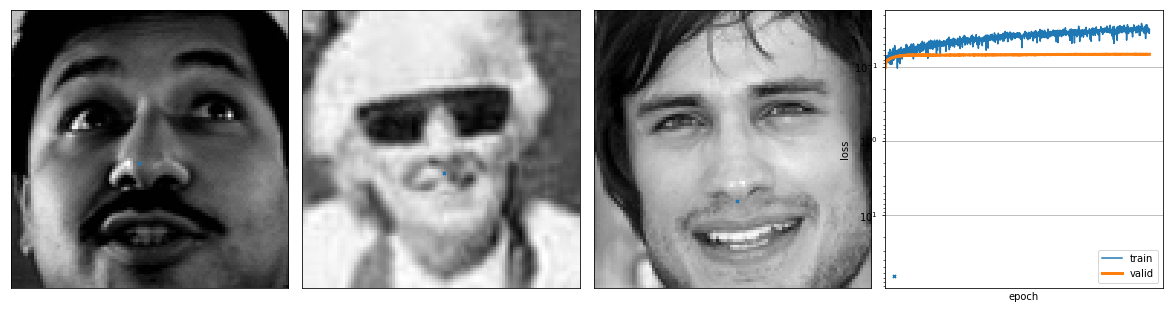





Count of observations in training data by features
left_eye_inner_corner_x     2271
left_eye_inner_corner_y     2271
right_eye_inner_corner_x    2268
right_eye_inner_corner_y    2268
left_eye_outer_corner_x     2267
left_eye_outer_corner_y     2267
right_eye_outer_corner_x    2268
right_eye_outer_corner_y    2268
Image                       7049
dtype: int64
done
Count of observations in training data by features
ImageId    1783
Image      1783
dtype: int64
done
Training data split into train and dev data
x_train.shape = = (1797, 9216); x_train.min == 0.000; x_train.max == 1.000
y_train.shape = = (1797, 8); y_train.min == -0.908; y_train.max == 0.985
x_dev.shape = = (450, 9216); x_dev.min == 0.000; x_dev.max == 1.000
y_dev.shape = = (450, 8); y_dev.min == -0.917; y_dev.max == 0.781
 RESTORING SESSION FOR WEIGHTS INITIALIZATION
INFO:tensorflow:Restoring parameters from /home/ubuntu/notebooks/models/basic_conv_net_/model.ckpt
 Model loaded from: /home/ubuntu/notebooks/models/basic_co

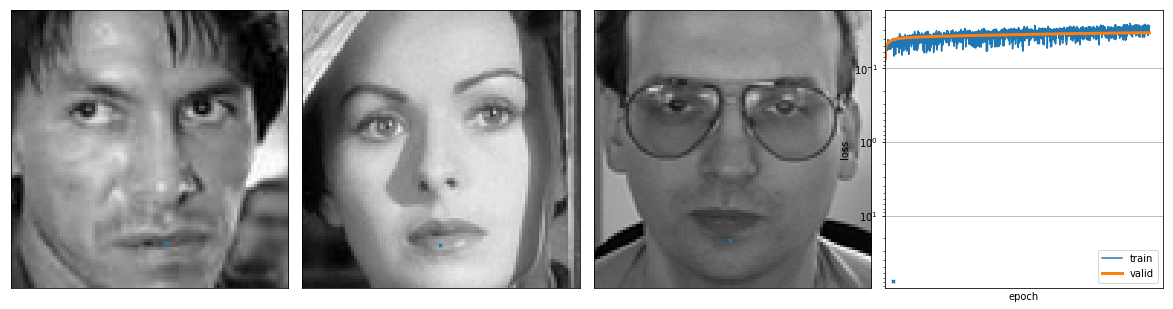





Count of observations in training data by features
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
Image                        7049
dtype: int64
done
Count of observations in training data by features
ImageId    1783
Image      1783
dtype: int64
done
Training data split into train and dev data
x_train.shape = = (1752, 9216); x_train.min == 0.000; x_train.max == 1.000
y_train.shape = = (1752, 8); y_train.min == -0.920; y_train.max == 0.964
x_dev.shape = = (438, 9216); x_dev.min == 0.000; x_dev.max == 1.000
y_dev.shape = = (438, 8); y_dev.min == -0.916; y_dev.max == 0.889
 RESTORING SESSION FOR WEIGHTS INITIALIZATION
INFO:tensorflow:Restoring parameters from /home/ubuntu/notebooks/models/basic_conv_net_/model.ckpt
 Model loaded from: /home/ubuntu/notebooks/models

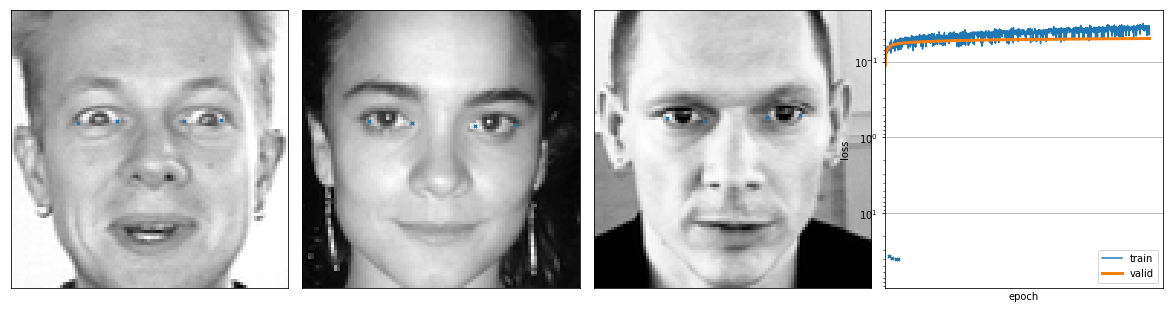





Count of observations in training data by features
left_eye_center_x     7039
left_eye_center_y     7039
right_eye_center_x    7036
right_eye_center_y    7036
Image                 7049
dtype: int64
done
Count of observations in training data by features
ImageId    1783
Image      1783
dtype: int64
done
Training data split into train and dev data
x_train.shape = = (5626, 9216); x_train.min == 0.000; x_train.max == 1.000
y_train.shape = = (5626, 4); y_train.min == -0.986; y_train.max == 0.973
x_dev.shape = = (1407, 9216); x_dev.min == 0.000; x_dev.max == 1.000
y_dev.shape = = (1407, 4); y_dev.min == -0.888; y_dev.max == 0.637
 RESTORING SESSION FOR WEIGHTS INITIALIZATION
INFO:tensorflow:Restoring parameters from /home/ubuntu/notebooks/models/basic_conv_net_/model.ckpt
 Model loaded from: /home/ubuntu/notebooks/models/basic_conv_net_/model.ckpt
0 Train loss:0.062 Dev loss:0.064 ratio train/dev:0.96
20 Train loss:0.072 Dev loss:0.055 ratio train/dev:1.32
40 Train loss:0.076 Dev loss:0

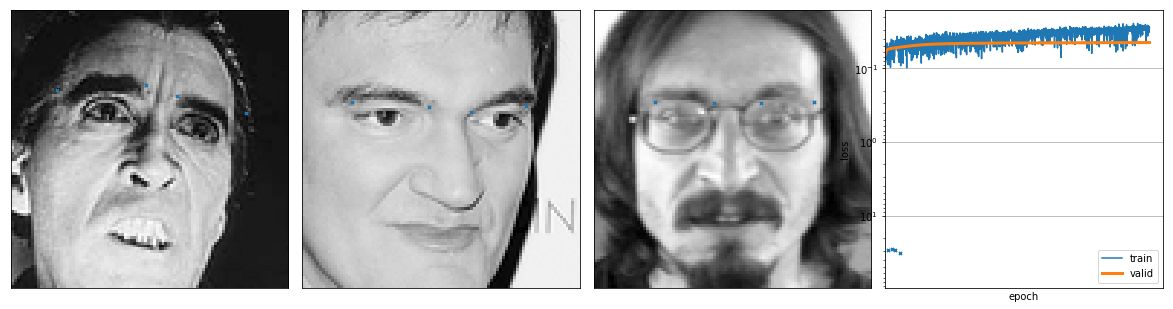





 Total time for all models:  4386.884194850922


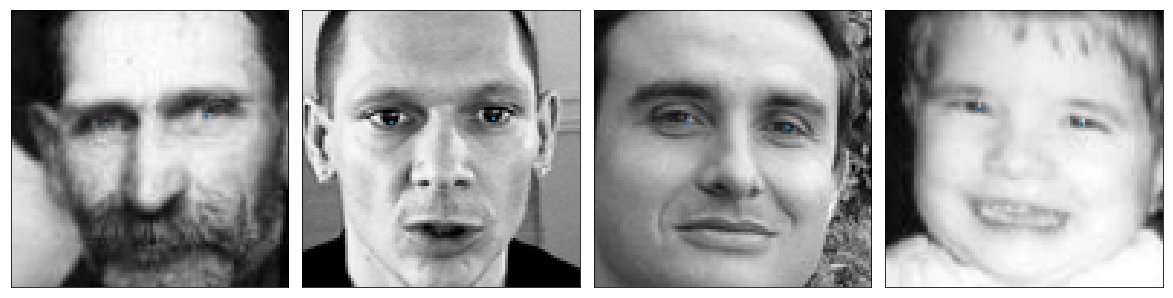

In [67]:
start = time.time()

for facial_model_label in facial_group_labels:
    train_individual_model(facial_model_label)

time_stop = time.time()    
print(" Total time for all models: " , time_stop - start)

In [68]:
# Plots history of learning curves for individual features  model. 
def plot_ind_model_curves(spec_name, color):
    
    train_history_path = FROOT + "/models/" + "ind_model_" + spec_name + "_"  + "/train_history"
    model_history = np.load(train_history_path + ".npz")
    train_loss = model_history["train_loss_history"][:,1]
    
    valid_loss = model_history["valid_loss_history"][:,1]
    
    x_axis = np.arange(n_epochs)
    
    label_name = spec_name.replace("_", " ")
    plt.plot(x_axis[train_loss > 0], train_loss[train_loss > 0], color + "--", linewidth=2, label = label_name)
    plt.plot(x_axis[valid_loss > 0], valid_loss[valid_loss > 0], color + "-", linewidth=2)
    
    return valid_loss

Mean loss from individual models: 0.0474


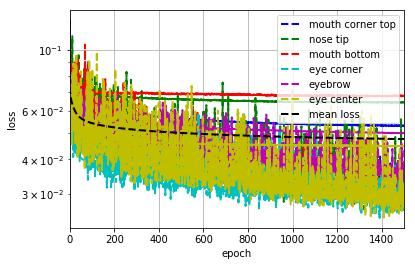

In [99]:
#Get mean loss from individual models 

colors = ["b", "g", "r", "c", "m", "y"]
weighted_valid_loss = np.zeros(n_epochs)
total_features = 0
for facial_model_label in facial_group_labels:
    valid_loss_ind = plot_ind_model_curves(facial_model_label['name'], colors[facial_group_labels.index(facial_model_label) % len(colors)])
    
    weighted_valid_loss += valid_loss_ind * len(facial_model_label['columns'])
    
    total_features += len(facial_model_label['columns'])
                               
    mean_loss = weighted_valid_loss/total_features

print("Mean loss from individual models: %0.4f"% mean_loss[-1])
x_axis = np.arange(n_epochs)
   

plt.plot(x_axis[mean_loss > 0], mean_loss[mean_loss > 0], "k" + "--", linewidth=2, label = "mean loss")
#plt.plot(x_axis[valid_loss > 0], valid_loss[valid_loss > 0], color + "-", linewidth=2, label = label_name)
                                

plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
#plt.ylim(0.0003, 0.1)
plt.xlim(0, n_epochs)
plt.yscale("log")
plt.show()